In [1]:
import warnings

warnings.filterwarnings("ignore")

import os
hf = r'../outputs/2.4_global_spatial_autocorrelation/'
os.makedirs(hf, exist_ok=True)

# 2.4 Global Spatial Autocorrelation 

In the Descriptive Market Statistics Chapter, a descriptive analysis of two datasets was conducted: student accommodations and higher education universities. However, in order to access spatial distribution across cities, it is necessary to measure spatial dependency.

Spatial autocorrelation measures spatial dependency. In other words, how much the value of a variable in a specific location is related to the values of the same variable at neighboring locations. Spatial autocorrelation (either positive or negative) is a key concept in geographic analysis. Spatial autocorrelation can be explained by the first law of geography. According to the law, objects in a neighborhood tend to have more similarities and interactions than those lying further away (Grekousis, 2020).

### Set Up 

Import Libraries

In [2]:
import os
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt  
import matplotlib as mpl 
import seaborn as sns 
from matplotlib.colors import LinearSegmentedColormap  
import matplotlib.patches as mpatches  
import matplotlib.patheffects as path_effects  
import geopandas as gpd  
from shapely.geometry import Point, MultiPoint  
from pyproj import CRS  
from scipy.stats import norm 
import libpysal  
from esda import Moran 
from libpysal.weights.spatial_lag import lag_spatial 
from libpysal.weights import KNN 
from libpysal.weights import weights

Colors

In [3]:
color_palettes = {
    "Mint": ["#EAF4E8", "#C8E0D4", "#A9CCC1", "#8FB9AE", "#76A79D", "#5F968E", "#498581"], 
    "Pi": ["#F8EDEB", "#FAE1DD", "#FCD5CE", "#FEC5BB", "#F8AD9D", "#F4978E", "#F08080"],
    "Or": ["#FFE5D9", "#FFD7BA", "#FEC89A", "#FFB78F", "#F49F7D", "#F28B6D", "#E1755CFF"],
    "GrSc":  ['#EFEFEF', '#D9D9D9', '#CCCCCC', '#B7B7B7', '#999999', '#666666', '#434343'],
    "MintPi": ["#76A79D", "#8FB9AE", "#A9CCC1", "#C8E0D4", "#FBF0EA", "#FCD5CE", "#FEC5BB", "#F8AD9D", "#F4978E"],
    "MintOr": ["#76A79D", "#8FB9AE", "#A9CCC1", "#C8E0D4", "#FBF0EA", "#FFD7BA", "#FEC89A", "#FFB78F", "#F28B6D"],
    "MiPiOr": ['#EAF4E8', '#FAE1DD', '#C8E0D4', '#FFD7BA', '#F8EDEB', '#FCD5CE', '#FFE5D9']
} 

from matplotlib.colors import LinearSegmentedColormap

cmap_mint = LinearSegmentedColormap.from_list("Mint", color_palettes["Mint"])
cmap_pi = LinearSegmentedColormap.from_list("Pi", color_palettes["Pi"])
cmap_or = LinearSegmentedColormap.from_list("Or", color_palettes["Or"])
cmap_mintpi = LinearSegmentedColormap.from_list("MintPi", color_palettes["MintPi"])
cmap_mintor = LinearSegmentedColormap.from_list("MintOr", color_palettes["MintOr"])
cmap_grsc = LinearSegmentedColormap.from_list("GrSc", color_palettes["GrSc"])
cmap_mipior = LinearSegmentedColormap.from_list("MiPiOr", color_palettes["MiPiOr"])

Font

In [4]:
plt.rcParams["font.family"] = "Helvetica"

Berlin Spatial Boundaries

In [5]:
pf = r"../inputs/2.4_global_spatial_autocorrelation/lor_pgr.gpkg"
pgr = gpd.read_file(pf)
pgr.replace({'-': np.nan, 0: np.nan, '': np.nan}, inplace=True)

bf = r"../inputs/2.4_global_spatial_autocorrelation/adm_bz.gpkg"
bz = gpd.read_file(bf)
bz.replace({'-': np.nan, 0: np.nan, '': np.nan}, inplace=True)

of = r"../inputs/2.4_global_spatial_autocorrelation/adm_out.gpkg"
out = gpd.read_file(of)
out.replace({'-': np.nan, 0: np.nan, '': np.nan}, inplace=True)

mf = r"../inputs/2.4_global_spatial_autocorrelation/berlin_mauer.gpkg"
mauer = gpd.read_file(mf)
mauer.replace({'-': np.nan, 0: np.nan, '': np.nan}, inplace=True)

# Student Accommodation Capacity

## Data Import

The data obtained as a result of Urban Data Mining was used as input data for the analysis (since no changes were made to the data during Descriptive Market Statistics).

In [6]:
pf = r"../inputs/2.4_global_spatial_autocorrelation/pbsa_c.gpkg"
pbsa_c = gpd.read_file(pf)

Before calculating global spatial autocorrelation, it is also necessary to perform tests: Moran's I Scatterplots Test and K-Nearest Neighbor Test, as well as calculate the Significance Threshold test.

Since the research focused on market parameters, global autocorrelation will focus on `capacity`, which measures the market supply. 

## Standartalisation

Data standardisation is used to assess the correlation of neighbouring values relative to the overall average and to eliminate the outliers identified in the previous chapter. Standardisation converts data into dimensionless values, which allows for accurate comparison of clustering for different student accommodations. Positive standardised capacity values (`!cap_std`) indicate above-average objects, while negative values indicate below-average objects. This will help to clearly identify student accommodation clusters in the future. 

In [7]:
pbsa_c["!cap_std"] = pbsa_c["!cap"] - pbsa_c["!cap"].mean()

## Moran's I Scatterplots Test & K-Nearest Neighbor Test

Several diagnostic measures can be used to identify spatial autocorrelation. Those that estimate spatial autocorrelation by a single value for the entire study area are named global spatial autocorrelation measures. The most commonly used is Moran’s I (Grekousis, 2020).

**Moran’s I** computes global spatial autocorrelation by taking into account  
feature locations and attribute values (of a single attribute) simultaneously. 
It is calculated by the following formula:

$$
I = \frac{n}{\sum_i \sum_j w_{ij}} \cdot 
\frac{\sum_i \sum_j w_{ij}(x_i - \bar{x})(x_j - \bar{x})}
{\sum_i (x_i - \bar{x})^2}
$$

where:  

n — number of spatial features  
xᵢ — attribute value of feature i (a variable in a spatial analysis context)  
xⱼ — attribute value of feature j   
x̄ — mean of this attribute  
wᵢⱼ — spatial weight between feature i and j    
∑ᵢ∑ⱼ wᵢⱼ — aggregation of all spatial weights

In order to calculate spatial weights between features, K-nearest neighbor weights are used. K-nearest neighbor weights are distance-based weights defines the neighbor set of a particular observation as containing its nearest observations, where the user specifies the number of nearest neighbors (`k`). If we do not test `k`, Moran’s I Index might have values beyond the [-1,1] boundaries (Grekousis, 2020). 

To understand the intuition behind its math, it is useful to begin with a graphical interpretation: the Moran Plot for different numbers of neighbors (Figure XX). The Moran Plot is a way of visualizing a spatial dataset to explore the nature and strength of spatial autocorrelation. It is essentially a traditional scatter plot in which the variable of interest is displayed against its spatial lag (Rey et al., 2023). 

The Moran’s I scatterplots (Figure XX) across increasing k-values (`k_values = list(range(1, 21))`) reveal that student accommodation capacity in Berlin exhibits a weak but consistently positive spatial autocorrelation, which strengthens as the neighborhood definition expands. Each point represents a student accommodation and its relationship to the capacities of its surrounding neighbors. The four quadrants provide insight into the spatial logic of student housing distribution:

**Q1 – High–High (HH)**     
These locations have high student accommodation capacity and are surrounded by other areas with similarly high capacities. These clusters signal where the market has already developed a strong supply.

**Q2 – Low–High (LH)**  
These student accommodations have low capacity themselves, but are neighboring high-capacity ones. They often represent transition zones—places that have the potential to absorb future student housing development because they border well-served districts. These locations highlight opportunity areas where relatively small additions could significantly improve spatial balance.

**Q3 – Low–Low (LL)**   
These locations exhibit low capacity and are surrounded by other low-capacity areas, marking systemic undersupply zones. For policy-making, these locations indicate structurally disadvantaged parts of the city, where students face limited options.

**Q4 – High–Low (HL)**  
These student accommodations have high capacity but are surrounded by low-capacity neighbors. Such areas represent isolated clusters—individual dorms or private student residences located in otherwise undersupplied districts. They highlight mismatches where supply exists but lacks integration into broader student housing networks, potentially limiting accessibility.

In conclusion, the Moran’s I scatterplots illustrate that Berlin’s student housing supply is spatially uneven, featuring concentrated high-capacity cores, isolated developments, transitional opportunity zones, and persistent undersupply areas.

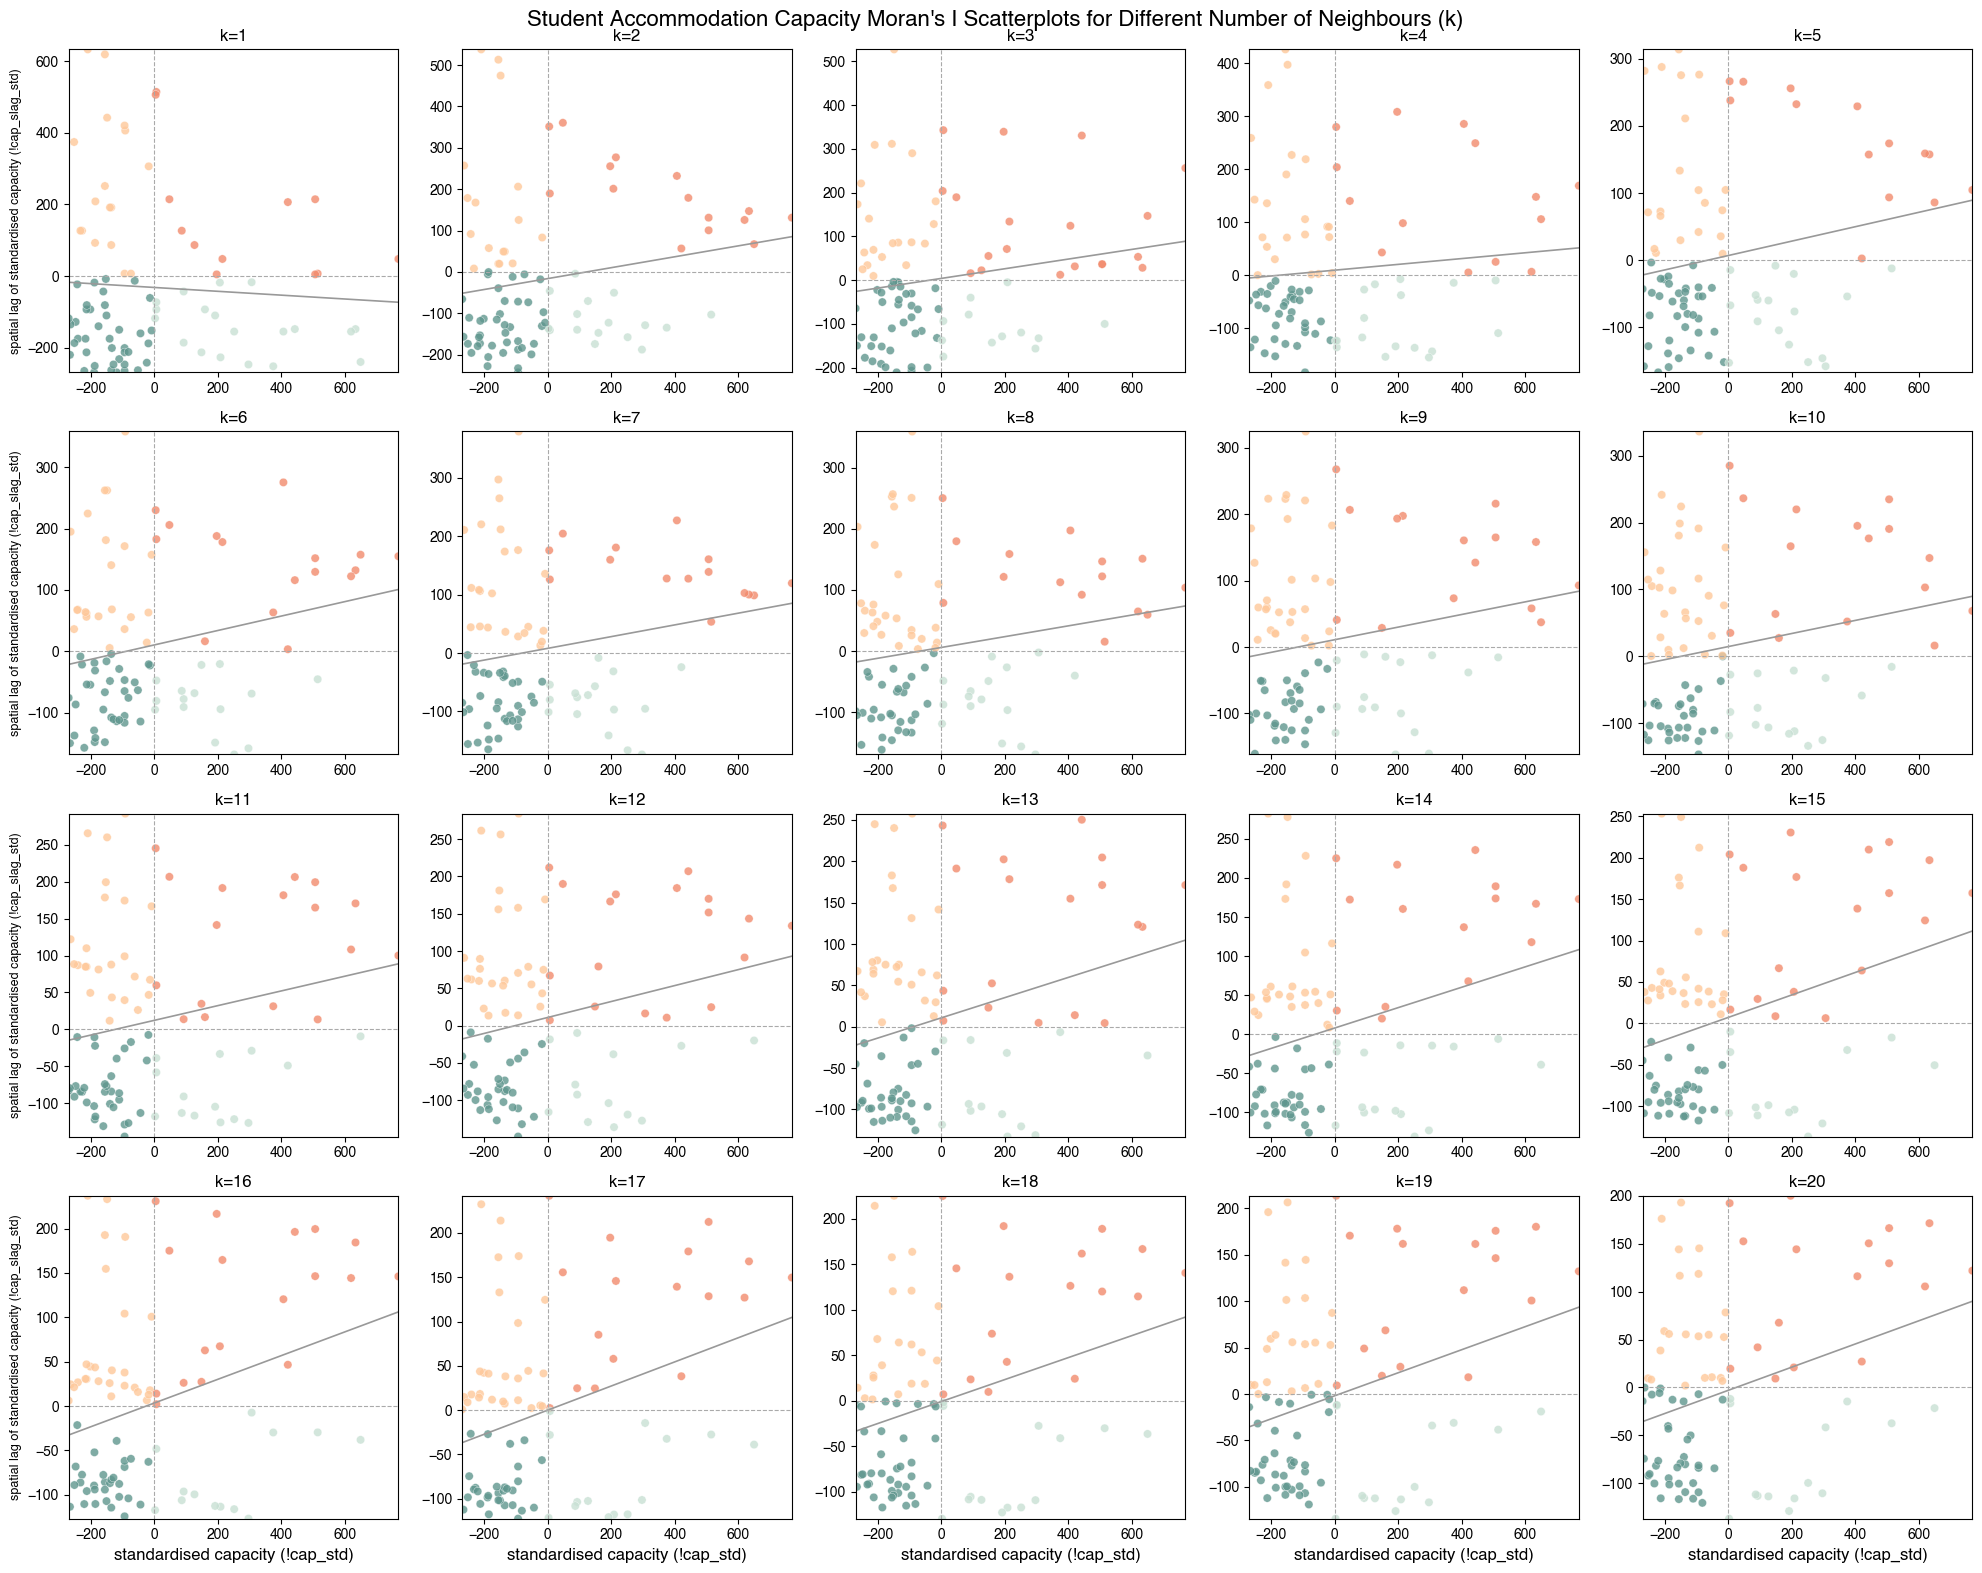

In [8]:
np.random.seed(55)

pbsa_c["!cap_std"] = pbsa_c["!cap"] - pbsa_c["!cap"].mean()

# Define k values and threshold
k_values = list(range(1, 21))
threshold = 1.0  # Customize this if needed

# Subplot grid
n_cols = 5
n_rows = (len(k_values) + n_cols - 1) // n_cols
n_plots = len(k_values)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

# Generate plots
def new_func(k, ax, moran_i, p_val):
    #ax.set_title(f'k={k}\nMoran\'s I = {moran_i:.3f}, P-value = {p_val:.3f}', fontsize=9)
    ax.set_title(f'k={k}', fontsize=12)

for i, k in enumerate(k_values):
    ax = axes[i]
    
    # Create spatial weights matrix
    w_k = libpysal.weights.KNN.from_dataframe(pbsa_c, k=k)
    w_k.transform = "R"
    
    # Compute spatial lag for this k
    slag_col = f'!cap_slag_std_k{k}'
    pbsa_c[slag_col] = lag_spatial(w_k, pbsa_c["!cap_std"])

    # Generate quadrant-based colors
    colors = []
    clusters = []
    for x, y in zip(pbsa_c['!cap_std'], pbsa_c[slag_col]):
        if abs(x) <= threshold and abs(y) <= threshold:
            colors.append('#FBF0EA')  # Cream = Not Significant
            clusters.append('NS')
        elif x > 0 and y > 0:
            colors.append('#F28B6D')  # Coral = High-High
            clusters.append('HH')
        elif x > 0 and y < 0:
            colors.append('#C8E0D4')  # Light teal = Low-High
            clusters.append('LH')
        elif x < 0 and y < 0:
            colors.append('#5F968E')  # Dark teal = Low-Low
            clusters.append('LL')
        elif x < 0 and y > 0:
            colors.append('#FEC89A')  # Peach = High-Low
            clusters.append('HL')
    
    # Scatter plot
    ax.scatter(
        pbsa_c['!cap_std'], pbsa_c[slag_col],
        c=colors, s=np.random.seed(55), edgecolor='white', linewidth=0.3, alpha=0.8
    )

    # Add regression line
    sns.regplot(
        x='!cap_std', y=slag_col, data=pbsa_c,
        scatter=False, ci=None, line_kws={"color": '#999999', "linewidth": 1.2}, ax=ax
    )

    # Axes
    ax.axvline(0, color='#aaaaaa', linestyle='--', linewidth=0.8)
    ax.axhline(0, color='#aaaaaa', linestyle='--', linewidth=0.8)

    # Moran calculation
    moran_k = Moran(pbsa_c['!cap'], w_k)
    moran_i = moran_k.I
    p_val = moran_k.p_sim

    # Title
    new_func(k, ax, moran_i, p_val)

    # Axis labels (only for edges)
    if i % n_cols == 0:
        ax.set_ylabel('spatial lag of standardised capacity (!cap_slag_std)', fontsize=9)
    if i >= n_plots - n_cols:
        ax.set_xlabel('standardised capacity (!cap_std)', fontsize=12)
    if i % n_cols != 0:
        ax.set_ylabel('')
    if i < n_plots - n_cols:
        ax.set_xlabel('')

    # Tight axes
    ax.set_xlim(pbsa_c['!cap_std'].min() - 0.1, pbsa_c['!cap_std'].max() + 0.1)
    ax.set_ylim(pbsa_c[slag_col].min() - 0.1, pbsa_c[slag_col].max() + 0.1)

# Hide any extra subplots
for j in range(len(k_values), len(axes)):
    axes[j].set_visible(False)

# Layout
fig.suptitle("Student Accommodation Capacity Moran's I Scatterplots for Different Number of Neighbours (k)", fontsize=16, y=0.98)
plt.subplots_adjust(top=0.93, hspace=0.5, wspace=0.5)

save_path = os.path.join(hf, "Student Accommodation Capacity Moran's I Scatterplots for Different Number of Neighbours (k).png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()

*Figure XX. Student Accommodation Capacity Moran's I Scatterplots for Different Number of Neighbours (k)*

The difference between the scatterplots (Figure XX) must be evaluated based on Moran’s I index and P-value. Through these metrics, we assess whether spatial autocorrelation is statistically significant. To do this, we need to calculate the parameters for each value of the number of nearest neighbors (`k`) (Table XX).

Moran’s I index and P-value can be interpreted as follows. A Moran’s I index score higher than 0.3 is an indication of relatively strong positive autocorrelation, while a score lower than -0.3 is an indication of relatively strong negative autocorrelation. If the p-value is large (usually p > 0.05), the results are not statistically significant, and we cannot reject spatial dependency (Grekousis, 2020). 

In [9]:
np.random.seed(55)

k_values = [ 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
morans_I = []
p_values = []

for k in k_values:
    w = libpysal.weights.KNN.from_dataframe(pbsa_c, k=k)
    w.transform = "R"
    moran = Moran(pbsa_c['!cap'], w)
    morans_I.append(moran.I)
    p_values.append(moran.p_sim)

# Create DataFrame
pbsa_k_test = pd.DataFrame({
    'k': k_values,
    "Moran's I": morans_I,
    'P-value': p_values
})

pbsa_k_test

,k,Moran's I,P-value
0,2,0.131920,0.076
1,3,0.110553,0.057
2,4,0.054687,0.163
3,5,0.107291,0.030
4,6,0.117724,0.017
5,7,0.100457,0.018
6,8,0.088330,0.039
7,9,0.095008,0.016
8,10,0.097889,0.012
9,11,0.099631,0.013


*Table XX. Student Accommodation Capacity Moran’s I index and P-value for Different Number of Neighbors (k)*

The task of finding the desired value of the number of nearest neighbors (`k`) can be solved by plotting a graph of the dependence of Moran's I index and P-value on k (Figure XX). On this graph, it is necessary to find the maximum values of the Moran's I index modulus and then compare the P-value. 

The maximum values of Moran's I index are achieved at k from 15 to 17. Since there are only 88 student dormitories, the minimum value of 15 neighbors (`k = 15`) was chosen. That is, each student dormitory is compared with its 15 closest neighbors in order to identify spatial dependence. 

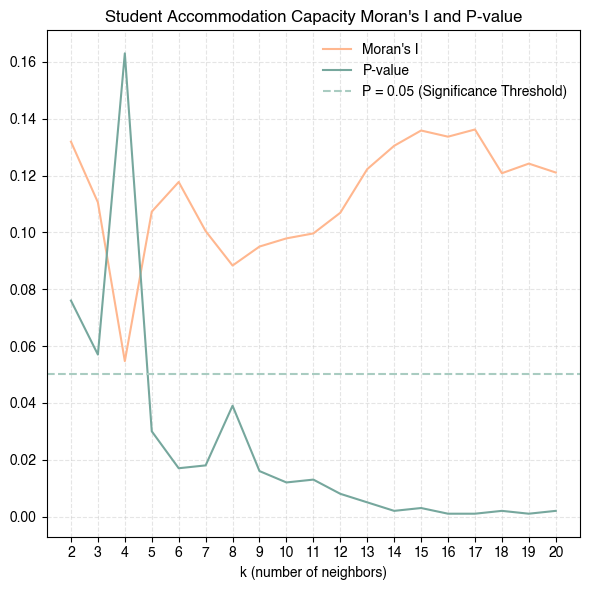

In [10]:
plt.figure(figsize=(6, 6))
plt.plot(pbsa_k_test['k'], pbsa_k_test["Moran's I"], label="Moran's I", color='#FFB78F')
plt.plot(pbsa_k_test['k'], pbsa_k_test['P-value'], label='P-value', color='#76A79D')

plt.axhline(0.05, color='#A9CCC1', linestyle='--', linewidth=1.5, label="P = 0.05 (Significance Threshold)")
plt.grid(True, color='#cccccc', linestyle='--', alpha=0.5)

plt.xlabel('k (number of neighbors)')
plt.title("Student Accommodation Capacity Moran's I and P-value")
plt.xticks(pbsa_k_test['k'])
plt.legend(loc='best', frameon=False)

save_path = os.path.join(hf, "Student Accommodation Capacity Moran's I and P-value.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()

*Figure XX. Student Accommodation Capacity Moran’s I index and P-value for Different Number of Neighbours (k)*

## Significance Threshold Test 

In the original Moran's I Scatterplots for Different Number of Neighbors (Figure XX), the points are distributed across four quadrants: HH, HL, LH, LL. However, points near zero may accidentally fall into false categories, even though they do not demonstrate real spatial dependence. This can lead to distorted results and the identification of false points of spatial autocorrelation. 

The Significance Threshold Test sets a significance threshold (`theshold`) for standardized capacity (`!cap_std`) and spatial lag standardized capacity (`!cap_slag_std`), and filters out not significant points where both variables take neutral values. 

In [11]:
# Option 1: Based on percentiles (recommended for your data)
threshold_percentile = np.percentile(np.abs(pbsa_c['!cap_std']), 75)  # 75th percentile of absolute values
print(f"Option 1 - Percentile-based threshold: {threshold_percentile:.3f}")
print(f"  (75th percentile of absolute values)")

# Option 2: Based on standard deviation
std_dev = pbsa_c['!cap_std'].std()
threshold_std = 0.5 * std_dev  # 0.5 standard deviations
print(f"Option 2 - Standard deviation-based threshold: {threshold_std:.3f}")
print(f"  (0.5 * standard deviation)")

# Option 3: Fixed threshold based on your data range
threshold_fixed = 50.0  # Fixed value appropriate for your range
print(f"Option 3 - Fixed threshold: {threshold_fixed:.3f}")
print(f"  (Fixed value for data range)")

# Option 4: Median-based threshold
median_abs = np.median(np.abs(pbsa_c['!cap_std']))
threshold_median = median_abs * 0.5
print(f"Option 4 - Median-based threshold: {threshold_median:.3f}")
print(f"  (0.5 * median of absolute values)")

thresholds_to_test = [threshold_percentile, threshold_std, threshold_fixed, threshold_median]

for i, test_threshold in enumerate(thresholds_to_test, 1):
    print(f"\nTest {i}: threshold = {test_threshold:.3f}")
    
    # Count points in each category
    ns_count = 0
    hh_count = 0
    lh_count = 0
    ll_count = 0
    hl_count = 0
    
    for x, y in zip(pbsa_c['!cap_std'], pbsa_c[slag_col]):
        if abs(x) <= test_threshold and abs(y) <= test_threshold:
            ns_count += 1
        elif x > 0 and y > 0:
            hh_count += 1
        elif x > 0 and y < 0:
            lh_count += 1
        elif x < 0 and y < 0:
            ll_count += 1
        elif x < 0 and y > 0:
            hl_count += 1
    
    total = len(pbsa_c)
    print(f"  NS: {ns_count} ({ns_count/total*100:.1f}%)")
    print(f"  HH: {hh_count} ({hh_count/total*100:.1f}%)")
    print(f"  LH: {lh_count} ({lh_count/total*100:.1f}%)")
    print(f"  LL: {ll_count} ({ll_count/total*100:.1f}%)")
    print(f"  HL: {hl_count} ({hl_count/total*100:.1f}%)")

Option 1 - Percentile-based threshold: 234.375
  (75th percentile of absolute values)
Option 2 - Standard deviation-based threshold: 124.090
  (0.5 * standard deviation)
Option 3 - Fixed threshold: 50.000
  (Fixed value for data range)
Option 4 - Median-based threshold: 78.750
  (0.5 * median of absolute values)

Test 1: threshold = 234.375
  NS: 66 (75.0%)
  HH: 8 (9.1%)
  LH: 6 (6.8%)
  LL: 6 (6.8%)
  HL: 2 (2.3%)

Test 2: threshold = 124.090
  NS: 25 (28.4%)
  HH: 15 (17.0%)
  LH: 10 (11.4%)
  LL: 26 (29.5%)
  HL: 12 (13.6%)

Test 3: threshold = 50.000
  NS: 6 (6.8%)
  HH: 16 (18.2%)
  LH: 12 (13.6%)
  LL: 35 (39.8%)
  HL: 19 (21.6%)

Test 4: threshold = 78.750
  NS: 11 (12.5%)
  HH: 16 (18.2%)
  LH: 12 (13.6%)
  LL: 35 (39.8%)
  HL: 14 (15.9%)


In order to correctly interpret the Significance Threshold Test, it is necessary to pay attention to the distribution of points across four squares - spatial clusters. 

**Option 1 - Percentile-based threshold: 234.375**  
With a high threshold value, 75% of the points became neutral, and the global autocorrelation analysis lost its meaning. 

**Option 2 - Standard deviation-based threshold: 124.090**  
It will eliminate the outliers that were described in the Descriptive Market Statistics chapter, as it is calculated according to the standard deviation.

**Option 3 - Fixed threshold: 50.000**  
A threshold value that is too low results in the percentage of neutral points being too low at 6.8%. 

**Option 4 - Median-based threshold: 78.750**   
Median-based threshold does not react to abnormally large values.
Therefore, this threshold creates a threshold that reflects the real “central” distribution structure (`threshold = threshold_median`).

Using three tests: Moran's I Scatterplots Test, K-Nearest Neighbour Test, and Significance Threshold Test, it can be confirmed that the results of local spatial autocorrelation are stable.

## Spatial Weights & Moran’s I & P-value

After performing all necessary tests, it is possible to proceed to the direct calculation of Spatial Weights, Moran’s I, and P-value for the selected value of numbers of nearest neighbors (`k=15`). To do this, the method of spatial weights standardization must be defined. Row-standardization (`w.transform = “R”`) makes Moran’s I and other spatial indices comparable between different areas, even if the number of neighbors for objects is different. For each row of the weight matrix (each object), the sum of all neighbor weights is normalized to 1. 

$$
w_{ij}^{(R)} = \frac{w_{ij}}{\sum_{j} w_{ij}}
$$

In [12]:
w = KNN.from_dataframe(pbsa_c, k=15)

w.transform = "R" 

values = pbsa_c['!cap']

moran = Moran(values, w)
print(f"Moran's I: {moran.I:.3f}")
print(f"P-value: {moran.p_sim:.3f}")

Moran's I: 0.136
P-value: 0.001


Moran's I (`Moran's I: 0.136`) indicates positive spatial autocorrelation. In the context of urban planning, this indicates that student accommodations have a weak but stable tendency to form clusters. 

P-value (`P-value: 0.001`) indicates that the probability of obtaining such a result by chance is 0.1%. In the context of urban planning, this shows that the observed spatial clusters actually exist and are not random. 

## Spatial Lag & Standardised Spatial Lag

After calculating spatial weights, it is necessary to compute the spatial lag. The spatial lag operator is one of the most common and direct applications of spatial weights matrices (called $\textbf{W}$ formally) in spatial analysis. Conceptually, the spatial lag captures the behavior of a variable in the immediate surroundings of each location; in that respect, it is akin to a local smoother of a variable (Rey et al., 2023). 

We can formally express it in matrix notation as:

$$
Y_{sl} = \textbf{W} Y
$$

or, in individual notation as:

$$
y_{sl-i} = \sum_j w_{ij} y_j
$$

where:  

$w_{ij}$ is the cell in $\textbf{W}$ on the $i$-th row and $j$-th column, thus capturing the spatial relationship between observations $i$ and $j$, in other words $y_{sl-i}$ is the weighted average values in a specified neighborhood.  
$y_{sl-i}$ thus captures the product of the values and weights of each observation other than $i$ in the dataset. 

Spatial lag is a key element of many spatial analysis techniques including spatial autocorrelation (Rey et al., 2023).

In [13]:
pbsa_c["!cap_slag"] = lag_spatial(w, pbsa_c["!cap"])
pbsa_c["!cap_std"] = pbsa_c["!cap"] - pbsa_c["!cap"].mean()
pbsa_c["!cap_slag_std"] = lag_spatial(w, pbsa_c["!cap_std"])

The maps (Figure XX) illustrate the various stages of data preparation for global autocorrelation — from actual capacity values (`!cap`) and their spatial relationships (`!cap_slag`) to their standardized values (`!cap_std` and `!cap_slag_std`).

**a. Student Housing Capacity (!cap)**  
The first map shows the absolute capacity of student housing. Despite the presence of large facilities in central areas, the overall structure remains fragmented, with significant heterogeneity between districts. This map reflects the actual market and serves as a starting point for analysis.

**b. Student Housing Capacity Influence (!cap_slag)**   
The second map displays the spatial lag of capacity — the average capacity in neighboring locations. It captures the influence of neighboring facilities, smoothing out local peaks and revealing latent clusters that are not visible in the absolute data. This shows not only where large dormitories are located, but also where their surroundings are saturated or deficient.

**c. Standardized Capacity (!cap_std)**     
The third map shows standardised values (centered around the mean). Here you can see which areas have above- or below-average capacity for the city, rather than simply “large/small.” This is a key step for Moran's I, as it allows you to identify deviations from the overall trend rather than absolute values.

**d. Standardized Capacity Influence (!cap_slag_std)**      
The fourth map displays standardized spatial lag—how much neighboring areas are above or below average. In combination with map (c), it shows where High–High (HH) and Low–Low (LL) clusters form and where anomalies (High–Low / Low–High) occur. These patterns form the basis for interpreting the Moran Scatterplot.

Together, maps (a–d) demonstrate that the distribution of student housing in Berlin is highly heterogeneous and structurally dependent on the spatial environment. The transition from absolute values (`!cap`) to standardized spatial lags (`!cap_slag_std`) allows us to identify hidden clusters and areas of shortage — key information for rethinking student housing placement strategies and developing spatially sensitive solutions.

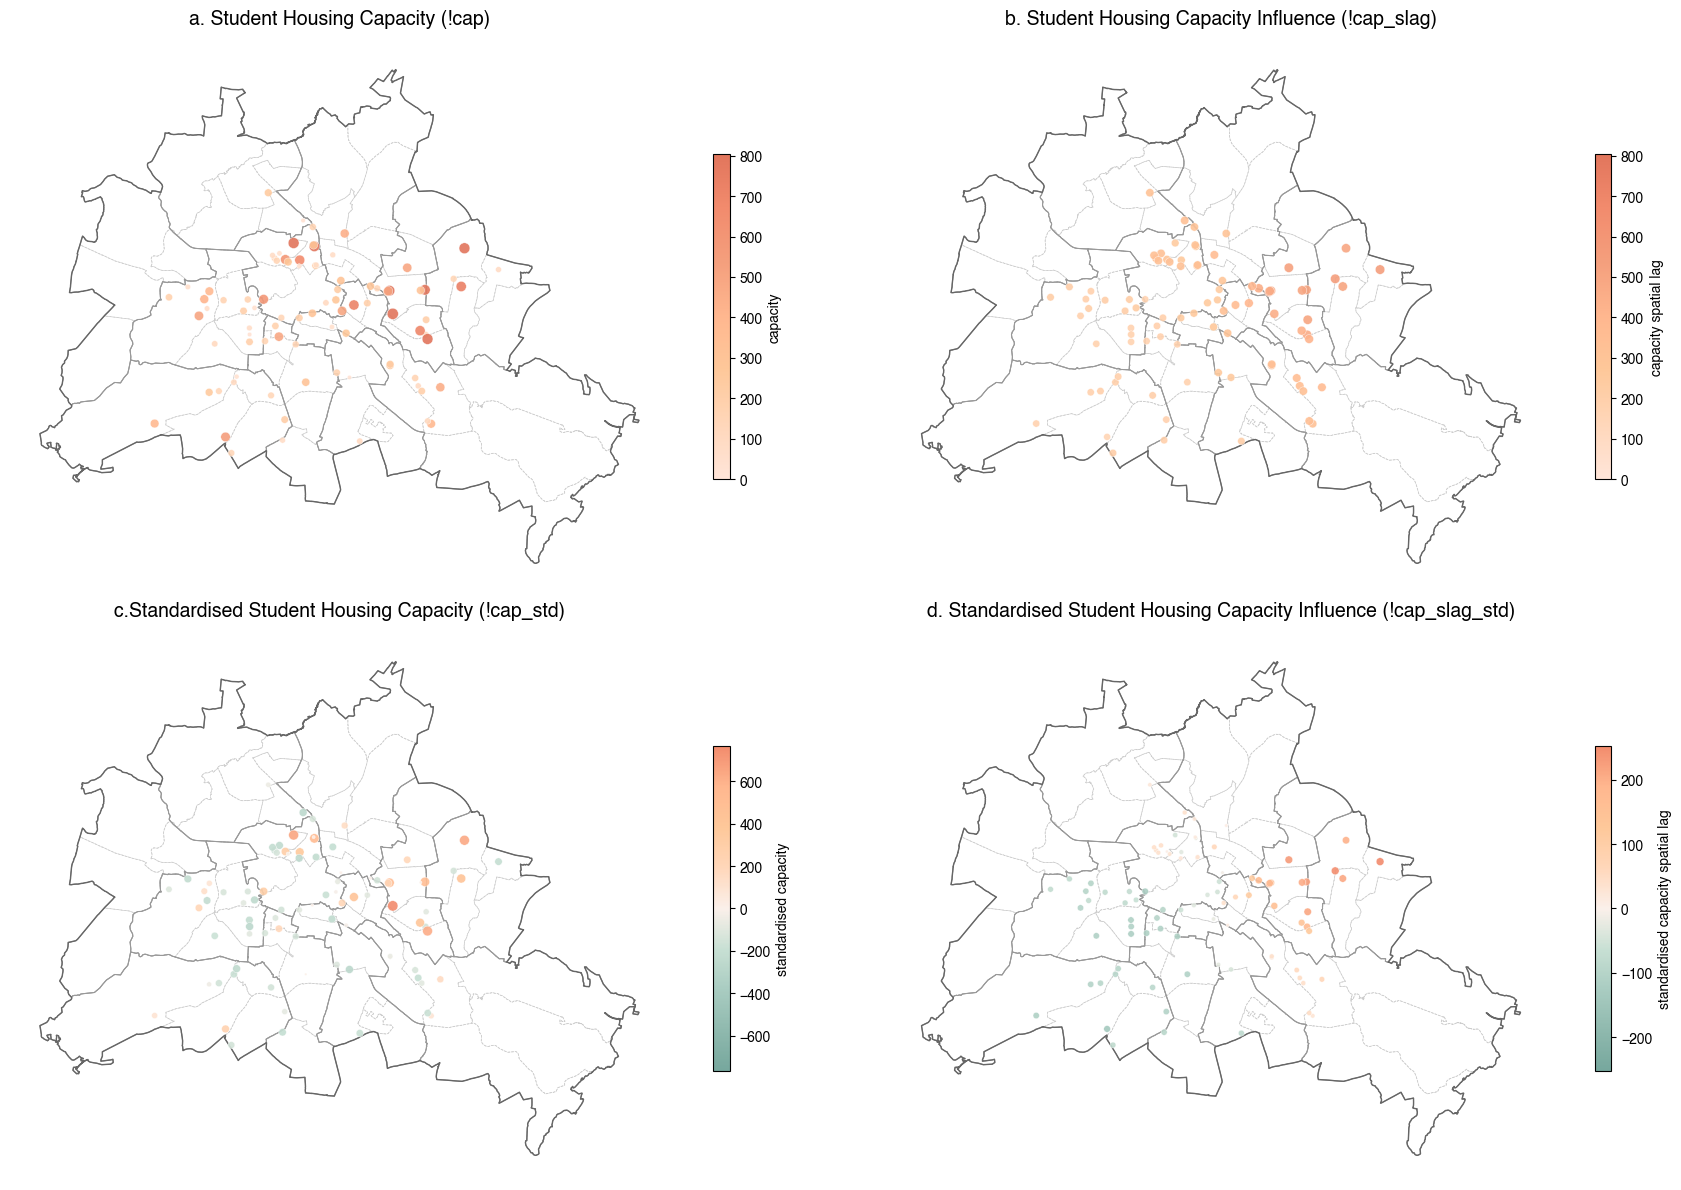

In [14]:
fig, axs  = plt.subplots(2, 2, figsize=(18, 12))

pgr.plot(ax=axs[0, 0], facecolor='none', edgecolor='#cccccc', linewidth=0.5, linestyle="--")
bz.plot(ax=axs[0, 0], facecolor='none', edgecolor='#999999', linewidth=0.75)
out.plot(ax=axs[0, 0], facecolor='none', edgecolor='#666666', linewidth=1)
pbsa_c.plot(ax=axs[0, 0],
          column='!cap',
          cmap=cmap_or,
          markersize = np.sqrt(pbsa_c['!cap']) * 2,  # Scale marker size
          alpha=0.9,
          edgecolor='white',
          linewidth=0.3,
          legend=True,
          legend_kwds={'shrink': 0.6, 'label': "capacity"},
          vmin=0,
          vmax=pbsa_c['!cap'].quantile(0.95))  # Cap extremes
axs[0, 0].set_title('a. Student Housing Capacity (!cap)', fontsize=14, pad=15, fontweight='bold')
axs[0, 0].set_axis_off()

pgr.plot(ax=axs[0, 1], facecolor='none', edgecolor='#cccccc', linewidth=0.5, linestyle="--")
bz.plot(ax=axs[0, 1], facecolor='none', edgecolor='#999999', linewidth=0.75)
out.plot(ax=axs[0, 1], facecolor='none', edgecolor='#666666', linewidth=1)
pbsa_c.plot(ax=axs[0, 1],
          column='!cap_slag',
          cmap=cmap_or,
          markersize=np.sqrt(pbsa_c['!cap_slag']) * 2,
          alpha=0.9,
          edgecolor='white',
          linewidth=0.3,
          legend=True,
          legend_kwds={'shrink': 0.6, 'label': "capacity spatial lag"},
          vmin=0,
          vmax=pbsa_c['!cap'].quantile(0.95))  # Matching Previous plott
axs[0, 1].set_title('b. Student Housing Capacity Influence (!cap_slag)', fontsize=14, pad=15, fontweight='bold')
axs[0, 1].set_axis_off()


max_abs_value = max(abs(pbsa_c['!cap_std'].min()), abs(pbsa_c['!cap_std'].max()))
vmin, vmax = -max_abs_value, max_abs_value
pgr.plot(ax=axs[1, 0], facecolor='none', edgecolor='#cccccc', linewidth=0.5, linestyle="--")
bz.plot(ax=axs[1, 0], facecolor='none', edgecolor='#999999', linewidth=0.75)
out.plot(ax=axs[1, 0], facecolor='none', edgecolor='#666666', linewidth=1)
pbsa_c.plot(ax=axs[1, 0],
          column='!cap_std',
          cmap=cmap_mintor,
          markersize = np.sqrt(np.abs(pbsa_c['!cap_std'])) * 2,  # Scale marker size
          alpha=0.9,
          edgecolor='white',
          linewidth=0.3,
          legend=True,
          legend_kwds={'shrink': 0.6, 'label': "standardised capacity"},
          vmin=vmin,  # Symmetrical lower bound
          vmax=vmax)      # Cap extremes
axs[1, 0].set_title('c.Standardised Student Housing Capacity (!cap_std)', fontsize=14, pad=15, fontweight='bold')
axs[1, 0].set_axis_off()

max_abs_value = max(abs(pbsa_c['!cap_slag_std'].min()), abs(pbsa_c['!cap_slag_std'].max()))
vmin, vmax = -max_abs_value, max_abs_value
pgr.plot(ax=axs[1, 1], facecolor='none', edgecolor='#cccccc', linewidth=0.5, linestyle="--")
bz.plot(ax=axs[1, 1], facecolor='none', edgecolor='#999999', linewidth=0.75)
out.plot(ax=axs[1, 1], facecolor='none', edgecolor='#666666', linewidth=1)
pbsa_c.plot(ax=axs[1, 1],
          column='!cap_slag_std',
          cmap=cmap_mintor,
          markersize=np.sqrt(np.abs(pbsa_c['!cap_slag_std'])) * 2,
          alpha=0.9,
          edgecolor='white',
          linewidth=0.3,
          legend=True,
          legend_kwds={'shrink': 0.6, 'label': "standardised capacity spatial lag"},
          vmin=vmin,  # Symmetrical lower bound
          vmax=vmax)
axs[1, 1].legend(loc='lower center', ncol=2, frameon=False, prop={'size': 10})
axs[1, 1].set_title('d. Standardised Student Housing Capacity Influence (!cap_slag_std)', fontsize=14, pad=15, fontweight='bold')
axs[1, 1].set_axis_off()

save_path = os.path.join(hf, "Standardised Student Housing Capacity.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()

*Figure XX. Stages of Preparing Student Accommodation Capacity Data*

Moran's graph shows the spatial relationship between the standardised capacity of student housing (`!cap_std`) and its spatial lag (`!cap_slag_std`) — that is, the average capacity of neighbouring locations. Dividing the graph into four quadrants allows us to identify types of spatial patterns:

**Q1 – High–High (HH)**     
These are high-capacity clusters where several large student residences are concentrated close to each other. For example, Studentenwohnheim Alfred-Jung-Straße, with a capacity of 800, is located less than 200 metres from another large student accommodation facility, WH Storkower Straße, with a capacity of 508 students, forming a stable centre for foreign students. At the same time, 12 of the 17 student facilities in the HH quadrant are state-owned. This leads to the conclusion that these centres of attraction are formed by state-owned facilities.

**Q2 – Low–High (LH)**
These are local pockets near developed clusters where a particular facility has low capacity compared to its saturated surroundings. For example, four facilities located in Wed: Norderoog, Studentenwohnheim Paul-Hertz-Haus, Süderoog, WH Augustenburger Platz with a total capacity of 471 students. Such areas are particularly important for analysis, as they may represent missed opportunities for growth.

**Q3 – Low–Low (LL)**   
These are supply shortage clusters where both the property and its surroundings have low capacity. For example, student accommodation in the direct vicinity of the Technical University of Berlin (Insider Apartments Leibniz Straße, WH Fraunhoferstraße, WH Hardenbergstraße). Such areas indicate structurally underserved areas – potential territories for development. 

**Q4 – High–Low (HL)**  
These are spatial anomalies where one large property appears in an environment where neighbouring areas have low supply. For example, Student Village Berlin Adlershof, is an early indicator of the development of new student areas.

The graph shows that the distribution of student housing capacity in Berlin includes both stable high-density clusters (HH) and structural gaps (LL), as well as a number of spatial anomalies (HL, LH), indicating uneven market development. These patterns describe indicators of the student housing crisis. 

In [15]:
# Define thresholds for "Not Significant"
threshold = threshold_median

# Prepare lists
colors = []
clusters = []

# Loop through each row
for x, y in zip(pbsa_c['!cap_std'], pbsa_c['!cap_slag_std']):
    if abs(x) <= threshold and abs(y) <= threshold:
        colors.append('#FBF0EA')         # Cream for Not Significant
        clusters.append('NS')            # Not Significant
    elif x > 0 and y > 0:
        colors.append('#F28B6D')         # Coral
        clusters.append('HH')            # High-High
    elif x > 0 and y < 0:
        colors.append('#C8E0D4')         # Light teal
        clusters.append('LH')            # Low-High
    elif x < 0 and y < 0:
        colors.append('#5F968E')         # Dark teal
        clusters.append('LL')            # Low-Low
    elif x < 0 and y > 0:
        colors.append('#FEC89A')         # Peach
        clusters.append('HL')            # High-Low

# Assign to GeoDataFrame
pbsa_c['color'] = colors
pbsa_c['cluster_cap'] = clusters

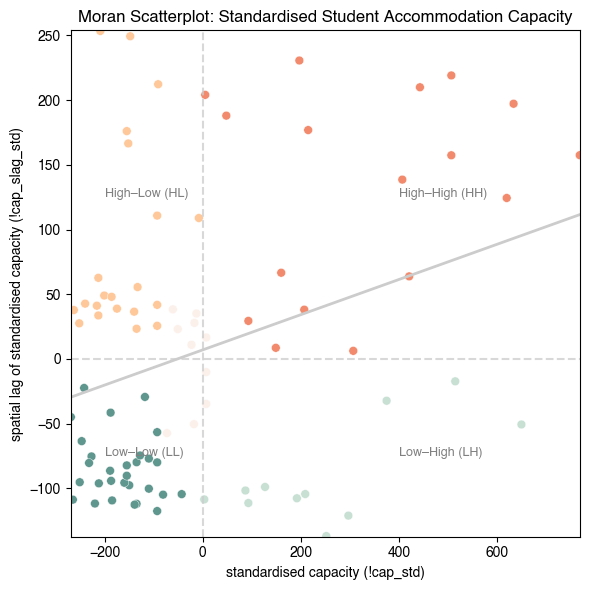

In [16]:
f, ax = plt.subplots(1, figsize=(6, 6))

# Scatter plot with manual colors
scatter = ax.scatter(
    x=pbsa_c['!cap_std'],
    y=pbsa_c['!cap_slag_std'],
    c=colors,  # Use our manually assigned colors
    s=40,
    edgecolor='white',
    linewidth=0.3
)

sns.regplot(
    x='!cap_std',
    y='!cap_slag_std',
    ci=None,
    data=pbsa_c,
    scatter=False,  # Disable default points
    line_kws={"color":'#cccccc', "linewidth": 2},
    ax=ax
)

# Axes lines
ax.axvline(0, color='#cccccc', alpha=0.75, linestyle="--")
ax.axhline(0, color='#cccccc', alpha=0.75, linestyle="--")

# Title and labels
ax.set_title("Moran Scatterplot: Standardised Student Accommodation Capacity", fontsize=12, weight='bold')
ax.set_xlabel("standardised capacity (!cap_std)", fontsize=10)
ax.set_ylabel("spatial lag of standardised capacity (!cap_slag_std)", fontsize=10)

# Quadrant labels
ax.text(400, 125, "High–High (HH)", fontsize=9, color="gray")
ax.text(400, -75, "Low–High (LH)", fontsize=9, color="gray")
ax.text(-200, -75, "Low–Low (LL)", fontsize=9, color="gray")
ax.text(-200, 125, "High–Low (HL)", fontsize=9, color="gray")

# Style
ax.set_xlim(pbsa_c['!cap_std'].min() - 0.5, pbsa_c['!cap_std'].max() + 0.5)
ax.set_ylim(pbsa_c['!cap_slag_std'].min() - 0.5, pbsa_c['!cap_slag_std'].max() + 0.5)

save_path = os.path.join(hf, "Moran Scatterplot: Standardised Student Accommodation Capacity")
plt.savefig(save_path, dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()

*Figure XX. Student Accommodation Capacity Moran Scatterplot*

The map (Figure XX) visualises the results of global spatial autocorrelation, which allows spatial clusters of student housing capacity to be identified.

In addition to identifying point clusters, the map clearly demonstrates the structural difference between East and West Berlin, which persists decades after the city's reunification. The map reveals clear spatial segregation. 

East Berlin shows a high concentration of large student complexes and compact clusters. In the districts of Lichtenberg, Marzahn-Hellersdorf, and parts of the central districts, large halls of residence (HH) are spatially clustered, indicating strategically strong market areas. Individual high-capacity facilities (HL) are located in areas with low supply (e.g., in the south-east of the city). This is partly due to the historical legacy of the former East Berlin, where student residences were actively developed as part of the social infrastructure.

Western Berlin, on the other hand, is characterised by a predominance of stable areas with low capacity and a shortage of supply. Areas of systemic shortage are concentrated mainly in Charlottenburg-Wilmersdorf, Tempelhof-Schöneberg, Neukölln, and Steglitz-Zehlendorf. Properties with low capacity are surrounded by large student complexes, most often in areas where local conditions or urban planning restrictions hinder expansion, such as in Mitte. This reflects a market that is more oriented towards the private rental sector, where student accommodation has developed more slowly.

The spatial distribution of student housing in Berlin remains uneven and historically conditioned: the east has concentrated large, state-owned housing clusters, while the west faces a systemic supply shortage. This asymmetry increases pressure on rental markets in western districts and serves as a key signal of the ongoing student housing crisis.

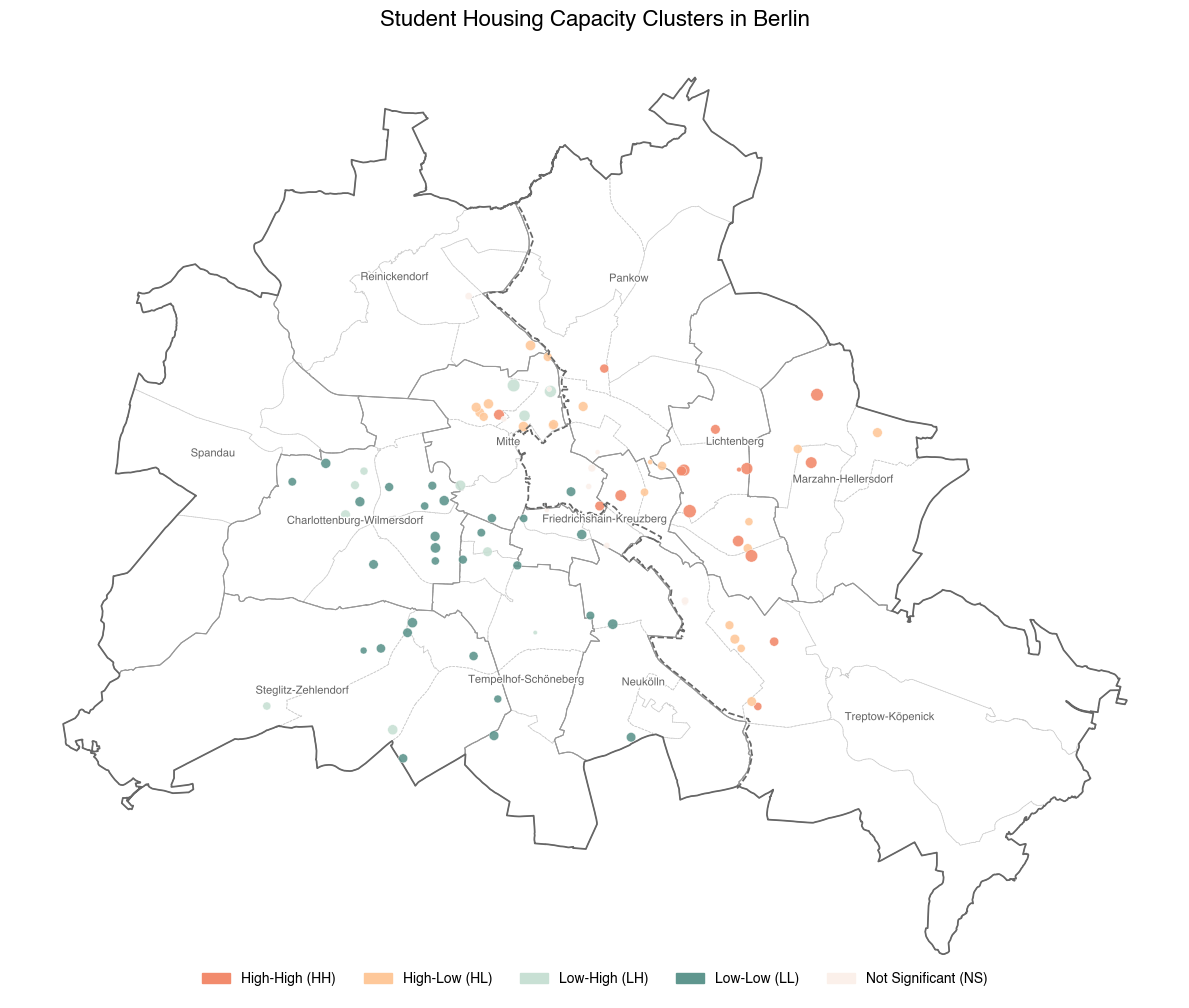

In [17]:
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the base map (replace 'lor' with your local authority boundaries if needed)

pgr.plot(ax=ax, facecolor='none', edgecolor='#cccccc', linewidth=0.5, linestyle="--")
mauer.plot(ax=ax, facecolor='none', edgecolor='#666666', linewidth=1.25, linestyle="--")
bz.plot(ax=ax, facecolor='none', edgecolor='#999999', linewidth=0.75)
for idx, row in bz.iterrows():
    centroid = row['geometry'].centroid
    txt = ax.text(
        centroid.x, centroid.y,
        str(row['namgem']),
        fontsize=8, color='#666666', ha='center', va='center'
    )
    txt.set_path_effects([
        path_effects.Stroke(linewidth=2, foreground='white'),
        path_effects.Normal()
    ])
out.plot(ax=ax, facecolor='none', edgecolor='#666666', linewidth=1.25)

# Plot the student housing with colors based on cluster classification
pbsa_c.plot(ax=ax,
            color=pbsa_c['color'],
            markersize=np.sqrt(np.abs(pbsa_c['!cap_std'])) * 3 + 5,  # Adjust size based on standardized capacity
            alpha=0.9,
            edgecolor='white',
            linewidth=0.3)

legend_elements = [
    mpatches.Patch(color='#F28B6D', label='High-High (HH)', edgecolor='none'),
    mpatches.Patch(color='#FEC89A', label='High-Low (HL)', edgecolor='none'),
    mpatches.Patch(color='#C8E0D4', label='Low-High (LH)', edgecolor='none'),
    mpatches.Patch(color='#5F968E', label='Low-Low (LL)', edgecolor='none'), 
    mpatches.Patch(color='#FBF0EA', label='Not Significant (NS)', edgecolor='#FAE1DD'), 
]

# Add the legend to the plot
ax.legend(handles=legend_elements, loc='lower center', ncol=5, frameon=False, prop={'size': 10})

# Add titles and customize the layout
ax.set_title('Student Housing Capacity Clusters in Berlin', fontsize=16, weight='bold')
ax.set_axis_off()

save_path = os.path.join(hf, "Student Housing Capacity Clusters in Berlin.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()

*Figure XX. Student Accommodation Capacity Clusters in Berlin*

## Data Export

The student accommodation data obtained from global spatial autocorrelation was stored for further market analysis. 

In [18]:
# List of columns to drop
cols_to_drop = [f'!cap_slag_std_k{i}' for i in range(1, 21)]

# Drop them from the GeoDataFrame
pbsa_c = pbsa_c.drop(columns=cols_to_drop)

In [19]:
ef = r'../outputs/2.4_global_spatial_autocorrelation/pbsa_capacity_analysis.gpkg'
pbsa_c.to_file(ef, driver="GPKG")

# Higher Education Universities International Demand

Similarly, an analysis of the spatial distribution of higher education university student demand across the city was conducted. 

## Data Import

In [20]:
uf = r'../inputs/2.4_global_spatial_autocorrelation/uni_c.gpkg'
uni_c = gpd.read_file(uf)

## Standartalisation

Since the research focused on international students, global autocorrelation will focus on number of international students (`!s_aus`), which measures the market demand.

In [21]:
uni_c["!s_aus_std"] = uni_c["!s_aus"] - uni_c["!s_aus"].mean()

## Moran’s I Scatterplots Test & K-Nearest Neighbor Test

Moran’s I Scatterplots (Figure XX) demonstrate how the spatial structure of international student demand changes as the number of nearest neighbours increases (`k_values = list(range(1, 21))`). The main conclusion is that, unlike the student housing market, demand from universities does not form stable spatial clusters. Most points in all graphs are concentrated near zero on the standardised international demand axis (`!s_aus_std`), indicating that neighbouring universities do not have a strong influence on demand values.

**Q1 – High–High (HH)**     
Unlike student dormitories, there are virtually no high-density clusters because large universities are located far from each other, and their demand values do not correlate with each other, i.e., universities attract foreign students regardless of their location. 

**Q2 – Low–High (LH)**  
These are local pockets near universities with a large number of foreign students, where a particular university has low demand compared to its saturated surroundings. 

**Q3 – Low–Low (LL)**   
For most values of the number of nearest neighbours (`k`), there is a high concentration of universities with a low number of foreign students surrounded by similar institutions. This indicates a generally uniform low density of international student demand across the city.

**Q4 – High–Low (HL)**  
Several universities with very high numbers of international students are isolated “peaks of demand”, not forming full-fledged spatial clusters.

In conclusion, Moran's I scatterplots illustrate that the demand generated by international students is structurally dispersed and does not form clusters across the city. 

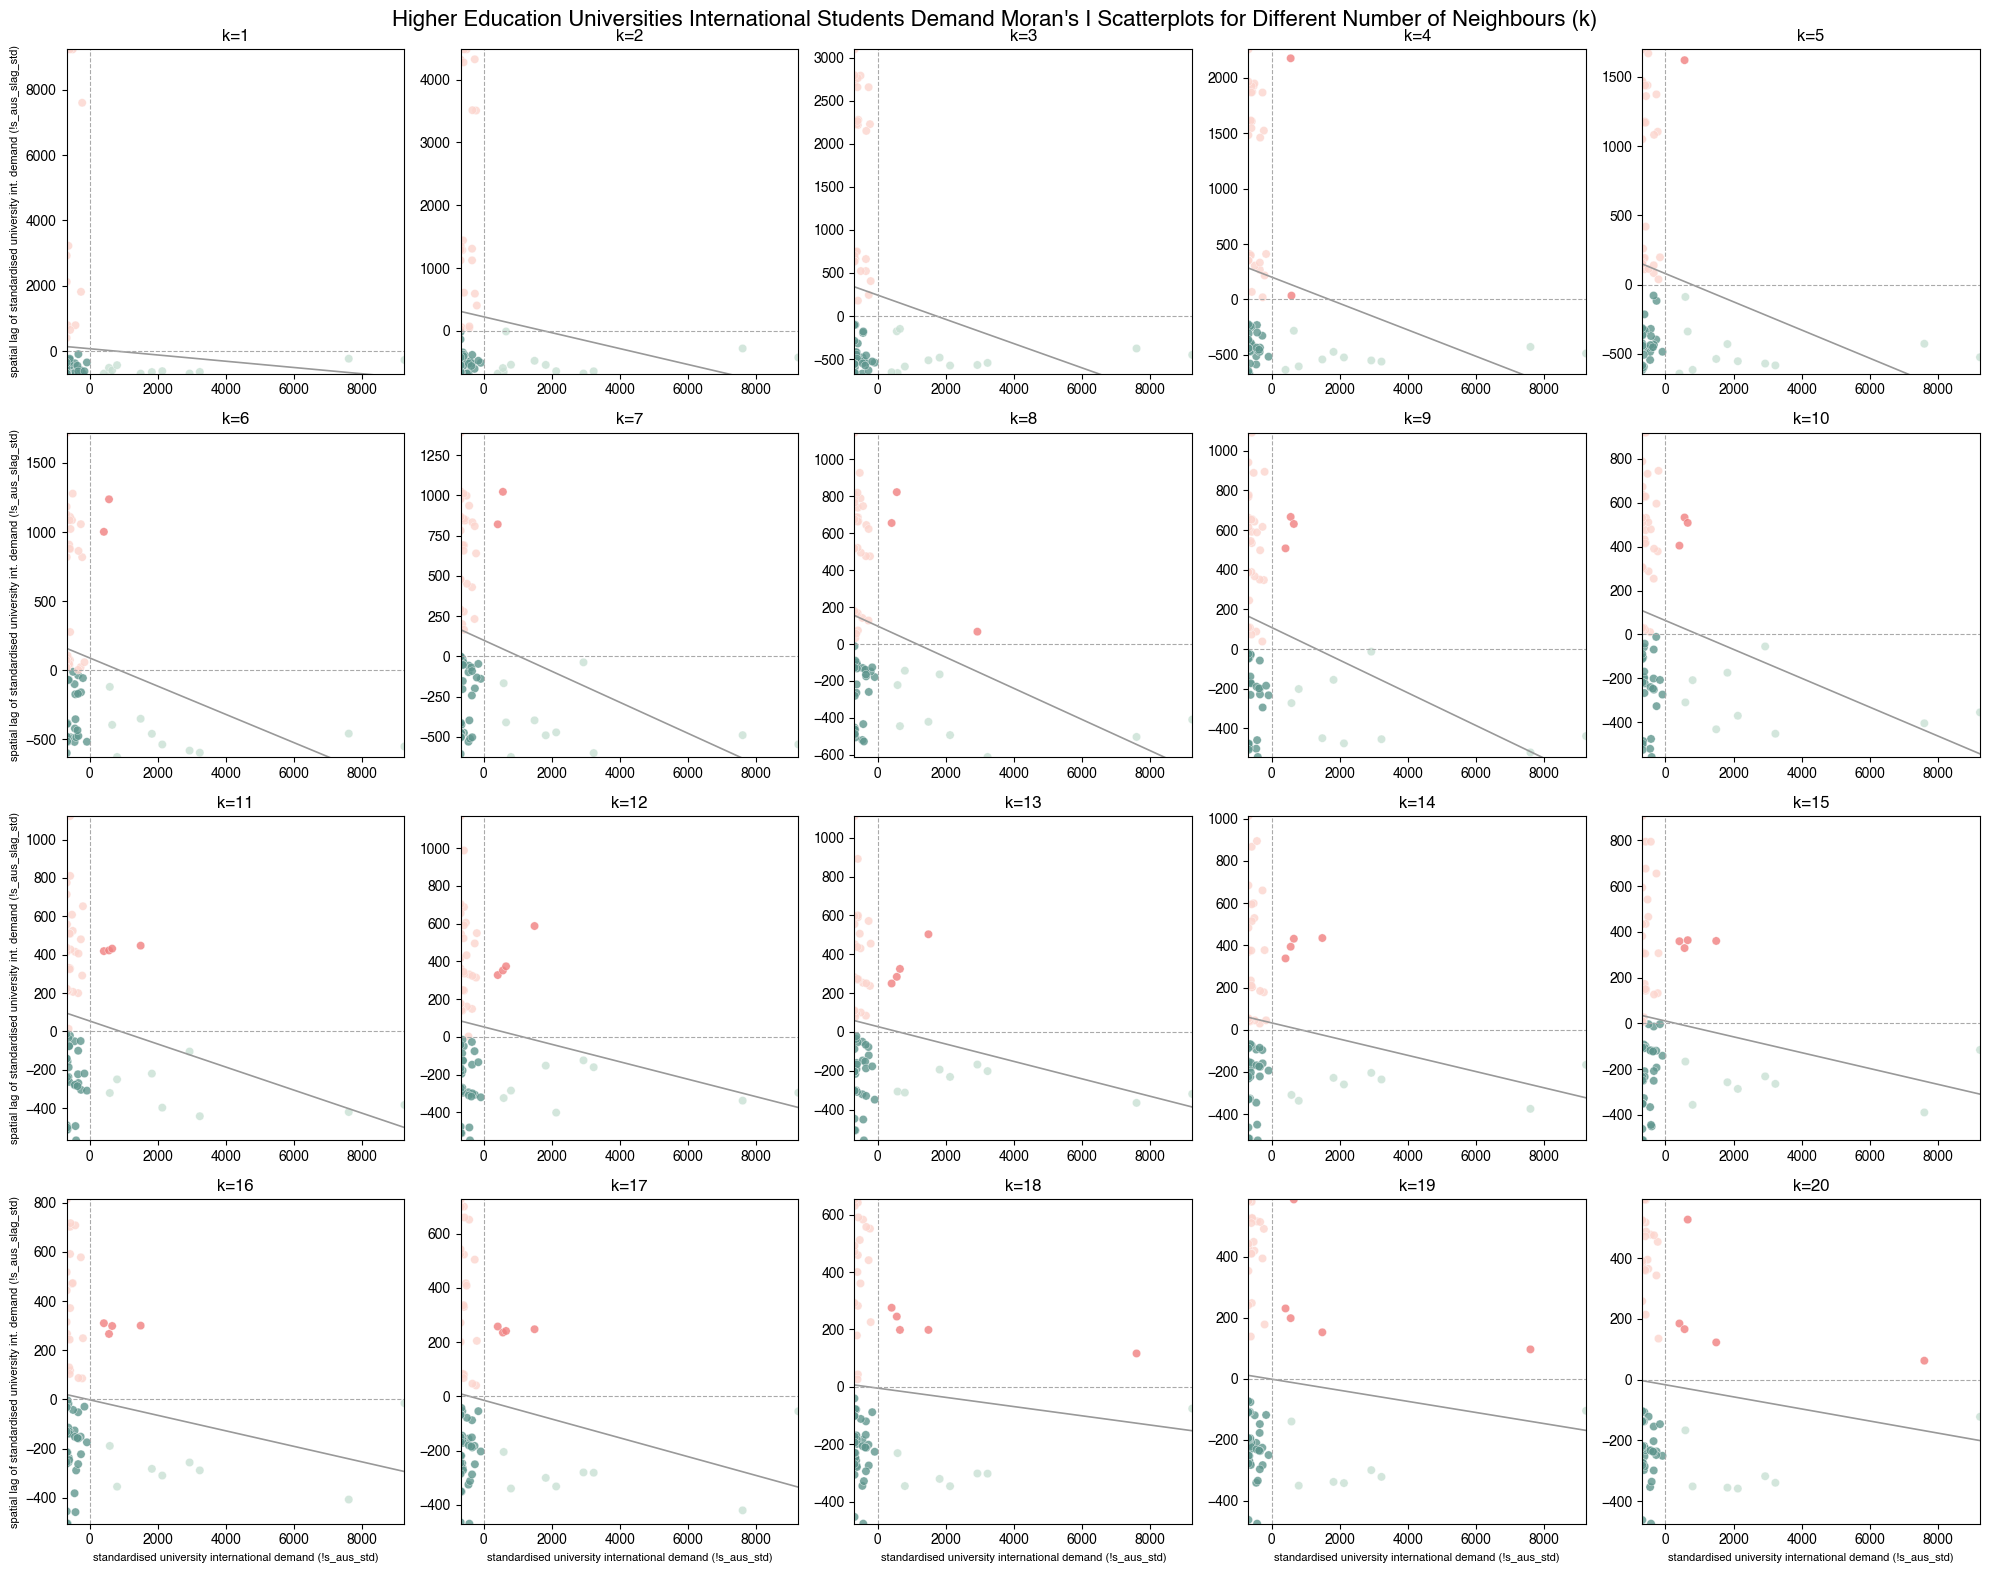

In [22]:
np.random.seed(55)

k_values = list(range(1, 21))
threshold = 1.0  # Customize this if needed

# Subplot grid
n_cols = 5
n_rows = (len(k_values) + n_cols - 1) // n_cols
n_plots = len(k_values)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

# Generate plots
for i, k in enumerate(k_values):
    ax = axes[i]
    
    # Create spatial weights matrix
    w_k = libpysal.weights.KNN.from_dataframe(uni_c, k=k)
    w_k.transform = "R"
    
    # Compute spatial lag for this k
    slag_col = f'!s_aus_slag_std_k{k}'
    uni_c[slag_col] = lag_spatial(w_k, uni_c["!s_aus_std"])

    # Generate quadrant-based colors
    colors = []
    clusters = []
    for x, y in zip(uni_c['!s_aus_std'], uni_c[slag_col]):
        if abs(x) <= threshold and abs(y) <= threshold:
            colors.append('#FBF0EA')         # Cream for Not Significant
            clusters.append('NS')
        elif x > 0 and y > 0:
            colors.append('#F08080')         # Pink
            clusters.append('HH')
        elif x > 0 and y < 0:
            colors.append('#C8E0D4')         # Light teal
            clusters.append('LH')
        elif x < 0 and y < 0:
            colors.append('#5F968E')         # Dark teal
            clusters.append('LL')
        elif x < 0 and y > 0:
            colors.append('#FCD5CE')         # Light Pink 
            clusters.append('HL')
    
    # Scatter plot
    ax.scatter(
        uni_c['!s_aus_std'], uni_c[slag_col],
        c=colors, s=np.random.seed(55), edgecolor='white', linewidth=0.3, alpha=0.8
    )

    # Add regression line
    sns.regplot(
        x='!s_aus_std', y=slag_col, data=uni_c,
        scatter=False, ci=None, line_kws={"color": '#999999', "linewidth": 1.2}, ax=ax
    )

    # Axes
    ax.axvline(0, color='#aaaaaa', linestyle='--', linewidth=0.8)
    ax.axhline(0, color='#aaaaaa', linestyle='--', linewidth=0.8)

    # Moran calculation
    moran_k = Moran(uni_c['!s_aus'], w_k)
    moran_i = moran_k.I
    p_val = moran_k.p_sim

    # Title
    ax.set_title(f'k={k}', fontsize=12)
    #ax.set_title(f'k={k}\nMoran\'s I = {moran_i:.3f}, P-value = {p_val:.3f}', fontsize=9)
    # Axis labels
    if i % n_cols == 0:
        ax.set_ylabel("spatial lag of standardised university int. demand (!s_aus_slag_std)", fontsize=8)
    if i >= len(k_values) - n_cols:
        ax.set_xlabel("standardised university international demand (!s_aus_std)", fontsize=8)
    if i % n_cols != 0:
        ax.set_ylabel('')
    if i < n_plots - n_cols:
        ax.set_xlabel('')

    # Tight axes
    ax.set_xlim(uni_c['!s_aus_std'].min() - 0.1, uni_c['!s_aus_std'].max() + 0.1)
    ax.set_ylim(uni_c[slag_col].min() - 0.1, uni_c[slag_col].max() + 0.1)

# Hide any extra subplots
for j in range(len(k_values), len(axes)):
    axes[j].set_visible(False)

# Layout
fig.suptitle("Higher Education Universities International Students Demand Moran's I Scatterplots for Different Number of Neighbours (k)", fontsize=16, y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.93, hspace=0.5, wspace=0.5)

save_path = os.path.join(hf, "Higher Education Universities International Students Demand Moran's I Scatterplots for Different Number of Neighbours (k).png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()

*Figure XX. Higher Education Universities International Students Demand Moran's I Scatterplots for Different Number of Neighbours (k)*

In [23]:
np.random.seed(55)

k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
morans_I = []
p_values = []

for k in k_values:
    w = libpysal.weights.KNN.from_dataframe(uni_c, k=k)
    w.transform = "R"
    moran = Moran(uni_c['!s_aus'], w)
    morans_I.append(moran.I)
    p_values.append(moran.p_sim)

# Create DataFrame
uni_k_test = pd.DataFrame({
    'k': k_values,
    "Moran's I": morans_I,
    'P-value': p_values
})

uni_k_test

,k,Moran's I,P-value
0,2,-0.126627,0.022
1,3,-0.140827,0.003
2,4,-0.119096,0.003
3,5,-0.101951,0.009
4,6,-0.102231,0.004
5,7,-0.096559,0.004
6,8,-0.084318,0.014
7,9,-0.082463,0.005
8,10,-0.065725,0.039
9,11,-0.060102,0.061


*Table XX. Higher Education Universities International Students Demand Moran’s I index and P-value for Different Number of Neighbors (k)*

The Moran's I distribution graph and P-value (Figure XX) show that the P-value takes acceptable values (P < 0.05) when k is between 2 and 10. Since we are talking about global spatial autocorrelation, the purpose of which is to identify patterns throughout Berlin, it is necessary to choose the maximum value of k. At the same time, the P-value when choosing 10 nearest neighbours is critically close to the significance threshold. Therefore, the previous value `k=9` was chosen.

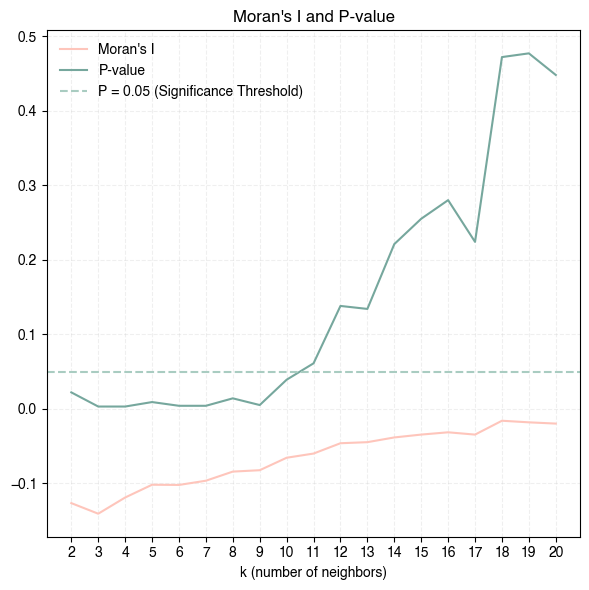

In [24]:
plt.figure(figsize=(6, 6))
plt.plot(uni_k_test['k'], uni_k_test["Moran's I"], label="Moran's I", color='#FEC5BB')
plt.plot(uni_k_test['k'], uni_k_test['P-value'], label='P-value', color='#76A79D')

plt.axhline(0.05, color='#A9CCC1', linestyle='--', linewidth=1.5, label="P = 0.05 (Significance Threshold)")
plt.grid(True, color='#cccccc', linestyle='--', alpha=0.3)

plt.xlabel('k (number of neighbors)')
plt.title("Moran's I and P-value")
plt.xticks(uni_k_test['k'])
plt.legend(loc='best', frameon=False)

save_path = os.path.join(hf, "International Students Demand Moran’s I index and P-value for Different Number of Neighbours (k).png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()

*Figure XX. Higher Education Universities International Students Demand Moran’s I index and P-value for Different Number of Neighbours (k)*

## Significance Threshold Test 

By analogy with student accommodation capacity, the significance threshold was calculated as half of the median of the absolute value (`median_abs * 0.5`). 

In [25]:
# Option 1: Based on percentiles (recommended for your data)
threshold_percentile = np.percentile(np.abs(uni_c['!s_aus_std']), 75)  # 75th percentile of absolute values
print(f"Option 1 - Percentile-based threshold: {threshold_percentile:.3f}")
print(f"  (75th percentile of absolute values)")

# Option 2: Based on standard deviation
std_dev = uni_c['!s_aus_std'].std()
threshold_std = 0.5 * std_dev  # 0.5 standard deviations
print(f"Option 2 - Standard deviation-based threshold: {threshold_std:.3f}")
print(f"  (0.5 * standard deviation)")

# Option 3: Fixed threshold based on your data range
threshold_fixed = 550.0  # Fixed value appropriate for your range
print(f"Option 3 - Fixed threshold: {threshold_fixed:.3f}")
print(f"  (Fixed value for your data range)")

# Option 4: Median-based threshold
median_abs = np.median(np.abs(uni_c['!s_aus_std']))
threshold_median = median_abs * 0.5
print(f"Option 4 - Median-based threshold: {threshold_median:.3f}")
print(f" (0.5 * median of absolute values)")

thresholds_to_test = [threshold_percentile, threshold_std, threshold_fixed, threshold_median]

for i, test_threshold in enumerate(thresholds_to_test, 1):
    print(f"\nTest {i}: threshold = {test_threshold:.3f}")
    
    # Count points in each category
    ns_count = 0
    hh_count = 0
    lh_count = 0
    ll_count = 0
    hl_count = 0
    
    for x, y in zip(uni_c['!s_aus_std'], uni_c[slag_col]):
        if abs(x) <= test_threshold and abs(y) <= test_threshold:
            ns_count += 1
        elif x > 0 and y > 0:
            hh_count += 1
        elif x > 0 and y < 0:
            lh_count += 1
        elif x < 0 and y < 0:
            ll_count += 1
        elif x < 0 and y > 0:
            hl_count += 1
    
    total = len(uni_c)
    print(f"  NS: {ns_count} ({ns_count/total*100:.1f}%)")
    print(f"  HH: {hh_count} ({hh_count/total*100:.1f}%)")
    print(f"  LH: {lh_count} ({lh_count/total*100:.1f}%)")
    print(f"  LL: {ll_count} ({ll_count/total*100:.1f}%)")
    print(f"  HL: {hl_count} ({hl_count/total*100:.1f}%)")

Option 1 - Percentile-based threshold: 679.990
  (75th percentile of absolute values)
Option 2 - Standard deviation-based threshold: 828.251
  (0.5 * standard deviation)
Option 3 - Fixed threshold: 550.000
  (Fixed value for your data range)
Option 4 - Median-based threshold: 304.745
 (0.5 * median of absolute values)

Test 1: threshold = 679.990
  NS: 54 (76.1%)
  HH: 2 (2.8%)
  LH: 6 (8.5%)
  LL: 5 (7.0%)
  HL: 4 (5.6%)

Test 2: threshold = 828.251
  NS: 64 (90.1%)
  HH: 2 (2.8%)
  LH: 5 (7.0%)
  LL: 0 (0.0%)
  HL: 0 (0.0%)

Test 3: threshold = 550.000
  NS: 23 (32.4%)
  HH: 4 (5.6%)
  LH: 7 (9.9%)
  LL: 23 (32.4%)
  HL: 14 (19.7%)

Test 4: threshold = 304.745
  NS: 5 (7.0%)
  HH: 5 (7.0%)
  LH: 7 (9.9%)
  LL: 34 (47.9%)
  HL: 20 (28.2%)


## Spatial Weights & Moran’s I & Spatial Lag

In [26]:
# Generate spatial weights from the GeoDataFrame
w = KNN.from_dataframe(uni_c, k=9) 
w.transform = "R"  # Row-standardize weights

values = uni_c['!s_aus']

moran = Moran(values, w)
print(f"Moran's I: {moran.I:.3f}")
print(f"P-value: {moran.p_sim:.3f}")

Moran's I: -0.082
P-value: 0.009


Moran's I (`Moran's I: -0.082`) indicates a weak negative spatial autocorrelation. In the context of urban planning, this indicates that higher education universities do not create spatial clusters; in other words, they are unevenly distributed throughout the city. 

P-value (`P-value: 0.007`) indicates that the probability of obtaining such a result by chance is 0.7%, i.e., the result obtained is statistically significant.

## Spatial Lag & Standardised Spatial Lag

In [27]:
# Add spatial lag and standardized columns
uni_c["!s_aus_slag"] = lag_spatial(w, uni_c["!s_aus"])
uni_c["!s_aus_std"] = uni_c["!s_aus"] - uni_c["!s_aus"].mean()
uni_c["!s_aus_slag_std"] = lag_spatial(w, uni_c["!s_aus_std"])

In [28]:
# Define thresholds for "Not Significant"
threshold = threshold_median

colors = []
clusters = []

for x, y in zip(uni_c['!s_aus_std'], uni_c['!s_aus_slag_std']):
    if abs(x) <= threshold and abs(y) <= threshold:
        colors.append('#FBF0EA')         # Cream for Not Significant
        clusters.append('NS')
    elif x > 0 and y > 0:
        colors.append('#F08080')         # Pink
        clusters.append('HH')
    elif x > 0 and y < 0:
        colors.append('#C8E0D4')         # Light teal
        clusters.append('LH')
    elif x < 0 and y < 0:
        colors.append('#5F968E')         # Dark teal
        clusters.append('LL')
    elif x < 0 and y > 0:
        colors.append('#FCD5CE')         # Light Pink 
        clusters.append('HL')

uni_c['color'] = colors
uni_c['cluster_aus'] = clusters

The maps (Figure XX) visualise the different stages of preparing international demand data for spatial analysis.

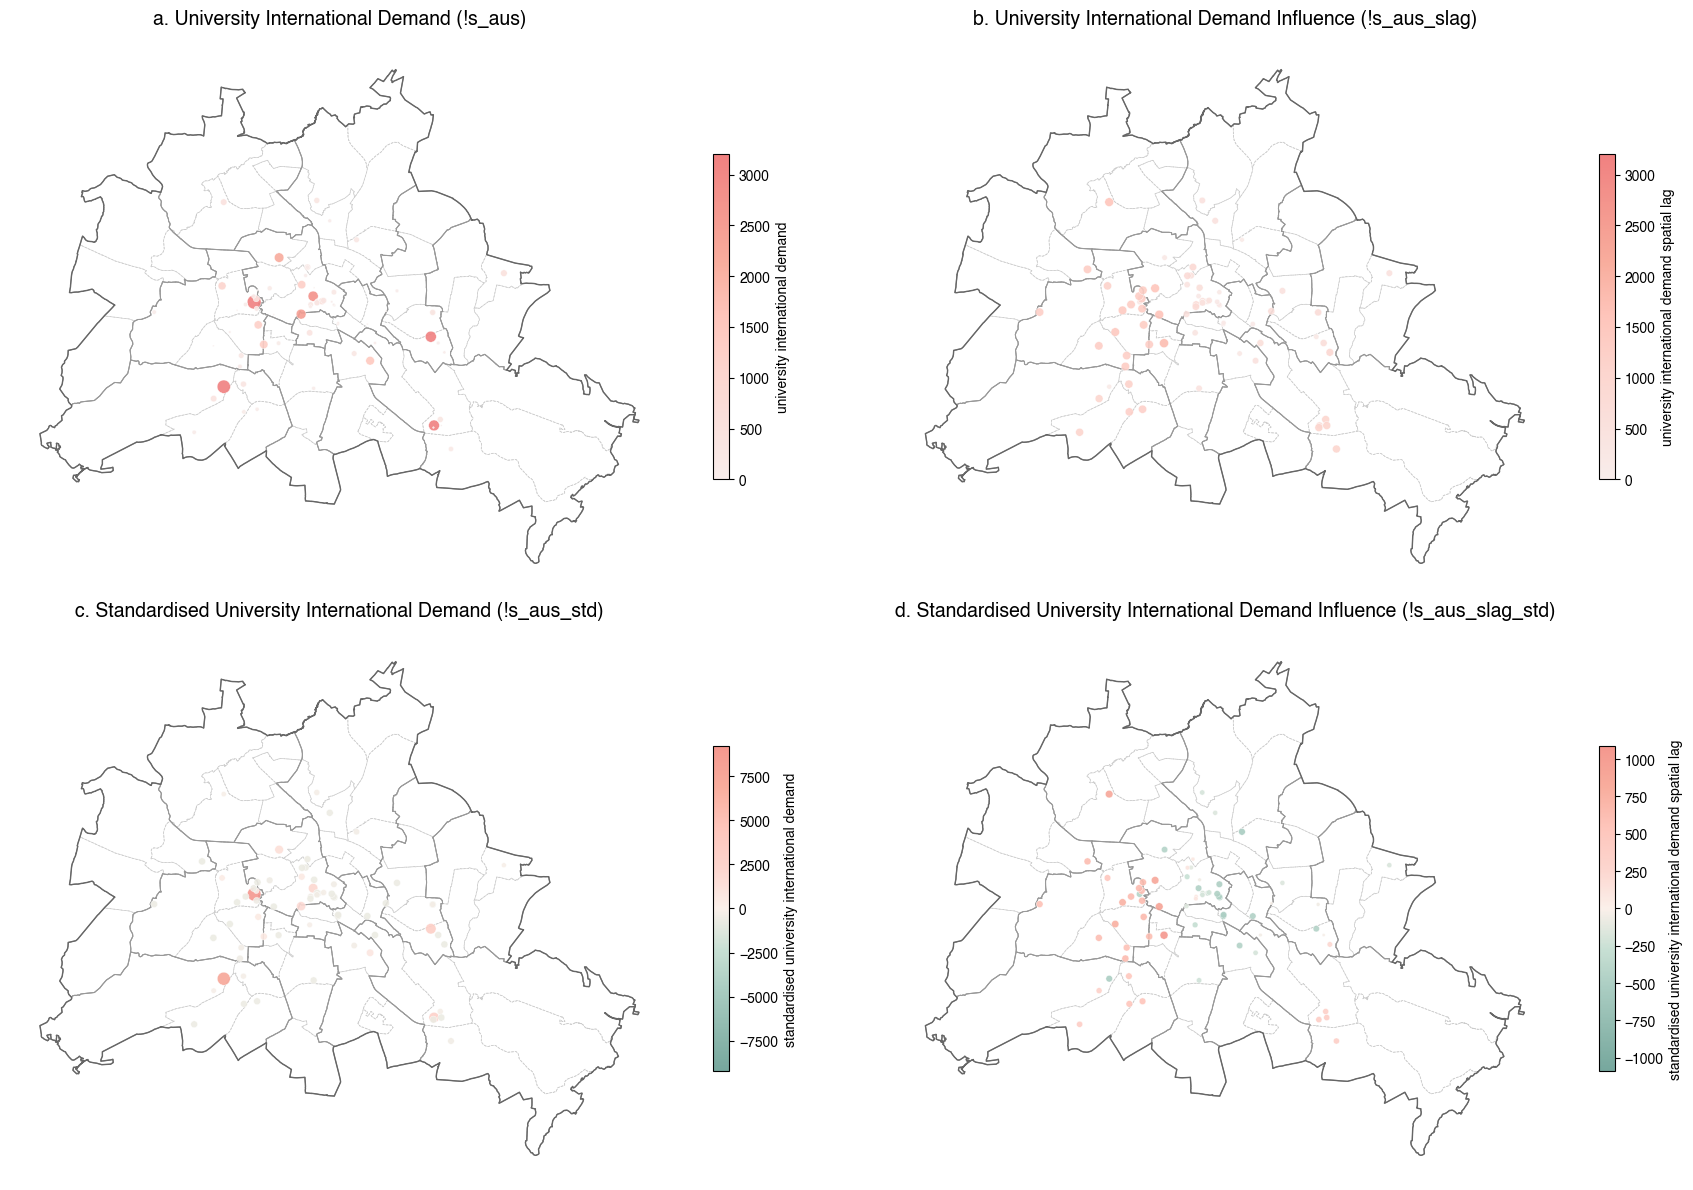

In [29]:
fig, axs  = plt.subplots(2, 2, figsize=(18, 12))

# a. University Demand (!s_aus)
pgr.plot(ax=axs[0, 0], facecolor='none', edgecolor='#cccccc', linewidth=0.5, linestyle="--")
bz.plot(ax=axs[0, 0], facecolor='none', edgecolor='#999999', linewidth=0.75)
out.plot(ax=axs[0, 0], facecolor='none', edgecolor='#666666', linewidth=1)
uni_c.plot(ax=axs[0, 0],
          column='!s_aus',
          cmap=cmap_pi,
          markersize = np.sqrt(uni_c['!s_aus']),
          alpha=0.9,
          edgecolor='white',
          linewidth=0.3,
          legend=True,
          legend_kwds={'shrink': 0.6, 'label': "university international demand"},
          vmin=0,
          vmax=uni_c['!s_aus'].quantile(0.95))
axs[0, 0].set_title('a. University International Demand (!s_aus)', fontsize=14, pad=15, fontweight='bold')
axs[0, 0].set_axis_off()

# b. University Demand Influence (!s_aus_slag)
pgr.plot(ax=axs[0, 1], facecolor='none', edgecolor='#cccccc', linewidth=0.5, linestyle="--")
bz.plot(ax=axs[0, 1], facecolor='none', edgecolor='#999999', linewidth=0.75)
out.plot(ax=axs[0, 1], facecolor='none', edgecolor='#666666', linewidth=1)
uni_c.plot(ax=axs[0, 1],
          column='!s_aus_slag',
          cmap=cmap_pi,
          markersize=np.sqrt(uni_c['!s_aus_slag']),
          alpha=0.9,
          edgecolor='white',
          linewidth=0.3,
          legend=True,
          legend_kwds={'shrink': 0.6, 'label': "university international demand spatial lag"},
          vmin=0,
          vmax=uni_c['!s_aus'].quantile(0.95))
axs[0, 1].set_title('b. University International Demand Influence (!s_aus_slag)', fontsize=14, pad=15, fontweight='bold')
axs[0, 1].set_axis_off()

# c. Standardised University Demand (!s_all_std)
max_abs_value = max(abs(uni_c['!s_aus_std'].min()), abs(uni_c['!s_aus_std'].max()))
vmin, vmax = -max_abs_value, max_abs_value
pgr.plot(ax=axs[1, 0], facecolor='none', edgecolor='#cccccc', linewidth=0.5, linestyle="--")
bz.plot(ax=axs[1, 0], facecolor='none', edgecolor='#999999', linewidth=0.75)
out.plot(ax=axs[1, 0], facecolor='none', edgecolor='#666666', linewidth=1)
uni_c.plot(ax=axs[1, 0],
          column='!s_aus_std',
          cmap=cmap_mintpi,
          markersize = np.sqrt(np.abs(uni_c['!s_aus_std'])),
          alpha=0.9,
          edgecolor='white',
          linewidth=0.3,
          legend=True,
          legend_kwds={'shrink': 0.6, 'label': "standardised university international demand"},
          vmin=vmin,
          vmax=vmax)
axs[1, 0].set_title('c. Standardised University International Demand (!s_aus_std)', fontsize=14, pad=15, fontweight='bold')
axs[1, 0].set_axis_off()

# d. Standardised University Demand Influence (!s_aus_slag_std)
max_abs_value = max(abs(uni_c['!s_aus_slag_std'].min()), abs(uni_c['!s_aus_slag_std'].max()))
vmin, vmax = -max_abs_value, max_abs_value
pgr.plot(ax=axs[1, 1], facecolor='none', edgecolor='#cccccc', linewidth=0.5, linestyle="--")
bz.plot(ax=axs[1, 1], facecolor='none', edgecolor='#999999', linewidth=0.75)
out.plot(ax=axs[1, 1], facecolor='none', edgecolor='#666666', linewidth=1)
uni_c.plot(ax=axs[1, 1],
          column='!s_aus_slag_std',
          cmap=cmap_mintpi,
          markersize=np.sqrt(np.abs(uni_c['!s_aus_slag_std'])),
          alpha=0.9,
          edgecolor='white',
          linewidth=0.3,
          legend=True,
          legend_kwds={'shrink': 0.6, 'label': "standardised university international demand spatial lag"},
          vmin=vmin,
          vmax=vmax)
axs[1, 1].legend(loc='lower center', ncol=2, frameon=False, prop={'size': 10})
axs[1, 1].set_title('d. Standardised University International Demand Influence (!s_aus_slag_std)', fontsize=14, pad=15, fontweight='bold')
axs[1, 1].set_axis_off()

save_path = os.path.join(hf, "Stages of Preparing Higher Education Universities International Students Demand Data.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()

*Figure XX. Stages of Preparing Higher Education Universities International Students Demand Data*

Moran's graph (Figure XX) visualises the spatial relationships between standardised international university demand (`!s_aus_std`) and its spatial lag (`!s_aus_slag_std`). The division into four quadrants allows us to identify characteristic spatial patterns of demand distribution and understand where areas of high competition or, conversely, a lack of educational attractiveness are forming.

**Q1 – High–High (HH)**     
These are clusters of high international demand, where universities with a large proportion of foreign students are located next to similarly significant neighbours. Such areas form stable ‘magnets’ for international students, for example, the College of Business and Law (HWR – 1,336 foreign students), the University of the Arts Berlin (UKB – 1,244 foreign students), and ESCP Business School Berlin (ESCP – 1,092 foreign students). At the same time, two of the three universities in the HH quadrant are publicly owned (HWR and UKB) and located in Willensdorf, while the private ESCP University is located in Charlottenburg. These three universities form a powerful spatial core of global education in West Berlin.

**Q2 – High–Low (HL)**  
Spatial anomalies, where a university with high international demand is located among neighbouring universities with low values. This is the largest cluster among all universities. It mainly consists of individual private universities that have a localised impact and signal the beginning of the formation of new educational centres. Among the universities belonging to the HL cluster but funded by the state are the Technical University of Berlin, the Protestant University of Applied Sciences Berlin, and the Charité – University Medicine Berlin campuses in the south-west of the city. 

**Q3 – Low–Low (LL)**   
Clusters of low demand, where both the university itself and its surroundings attract relatively few foreign students. LL zones indicate areas where international educational activity is weak, such as Pankow, Lichtenberg, Friedrichshain-Kreuzberg, and Neukölln. Among the reasons for unrealised educational potential, one can assume a lack of infrastructure, limited academic activity, or weak integration into the city's structure.

**Q4 – Low–High (LH)**  
These are local failures, where a university demonstrates low international demand, but its environment demonstrates high demand. At the same time, seven of the nine universities in the LH quadrant are publicly owned. Universities such as the Free University of Berlin and Humboldt University of Berlin have the potential to participate in existing educational clusters, but are not yet strategically integrated into them.

This distribution indicates competition between universities, the existence of ‘hot spots’ of international activity, and, at the same time, structural territorial gaps.
All these patterns are important for studying the student housing crisis, as international demand directly correlates with increased pressure on the rental market, especially in highly attractive local clusters.

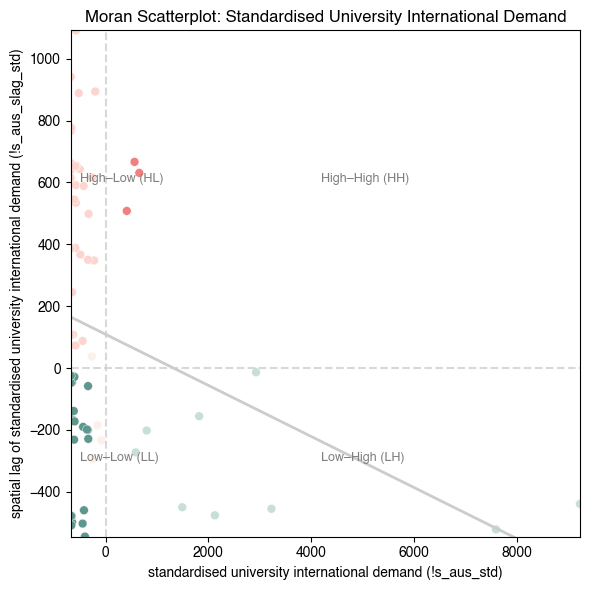

In [30]:
f, ax = plt.subplots(1, figsize=(6, 6))

scatter = ax.scatter(
    x=uni_c['!s_aus_std'],
    y=uni_c['!s_aus_slag_std'],
    c=colors,
    s=40,
    edgecolor='white',
    linewidth=0.3
)

sns.regplot(
    x='!s_aus_std',
    y='!s_aus_slag_std',
    ci=None,
    data=uni_c,
    scatter=False,
    line_kws={"color":'#cccccc', "linewidth": 2},
    ax=ax
)

ax.axvline(0, color='#cccccc', alpha=0.75, linestyle="--")
ax.axhline(0, color='#cccccc', alpha=0.75, linestyle="--")

ax.set_title("Moran Scatterplot: Standardised University International Demand", fontsize=12, weight='bold')
ax.set_xlabel("standardised university international demand (!s_aus_std)", fontsize=10)
ax.set_ylabel("spatial lag of standardised university international demand (!s_aus_slag_std)", fontsize=10)

ax.text(4200, 600, "High–High (HH)", fontsize=9, color="gray")
ax.text(4200, -300, "Low–High (LH)", fontsize=9, color="gray") 
ax.text(-500, -300, "Low–Low (LL)", fontsize=9, color="gray") #
ax.text(-500, 600, "High–Low (HL)", fontsize=9, color="gray") #


ax.set_xlim(uni_c['!s_aus_std'].min() - 0.5, uni_c['!s_aus_std'].max() + 0.5)
ax.set_ylim(uni_c['!s_aus_slag_std'].min() - 0.5, uni_c['!s_aus_slag_std'].max() + 0.5)

save_path = os.path.join(hf, "Higher Education Universities International Students Demand Moran Scatterplot.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()

*Figure XX. Higher Education Universities International Students Demand Moran Scatterplot*

The map showing the spatial distribution of international student demand in Berlin (Figure XX) reveals that, unlike the supply of student housing, demand does not form stable clusters of high concentration. Instead of the expected spatial agglomeration around large public universities, there is a dispersion (scattering) of values. In other words, universities with high numbers of international students are not grouped geographically, but rather distributed in a fragmented manner and often separated from similar neighbours.

The east-west divide highlights Berlin's historical asymmetry: the West traditionally concentrates international academic demand, while the East remains unattractive in an international context.

The demand for international students is distributed more chaotically and does not correlate with the spatial patterns of student housing supply, which exacerbates the structural imbalance between the housing market and the city's academic infrastructure.

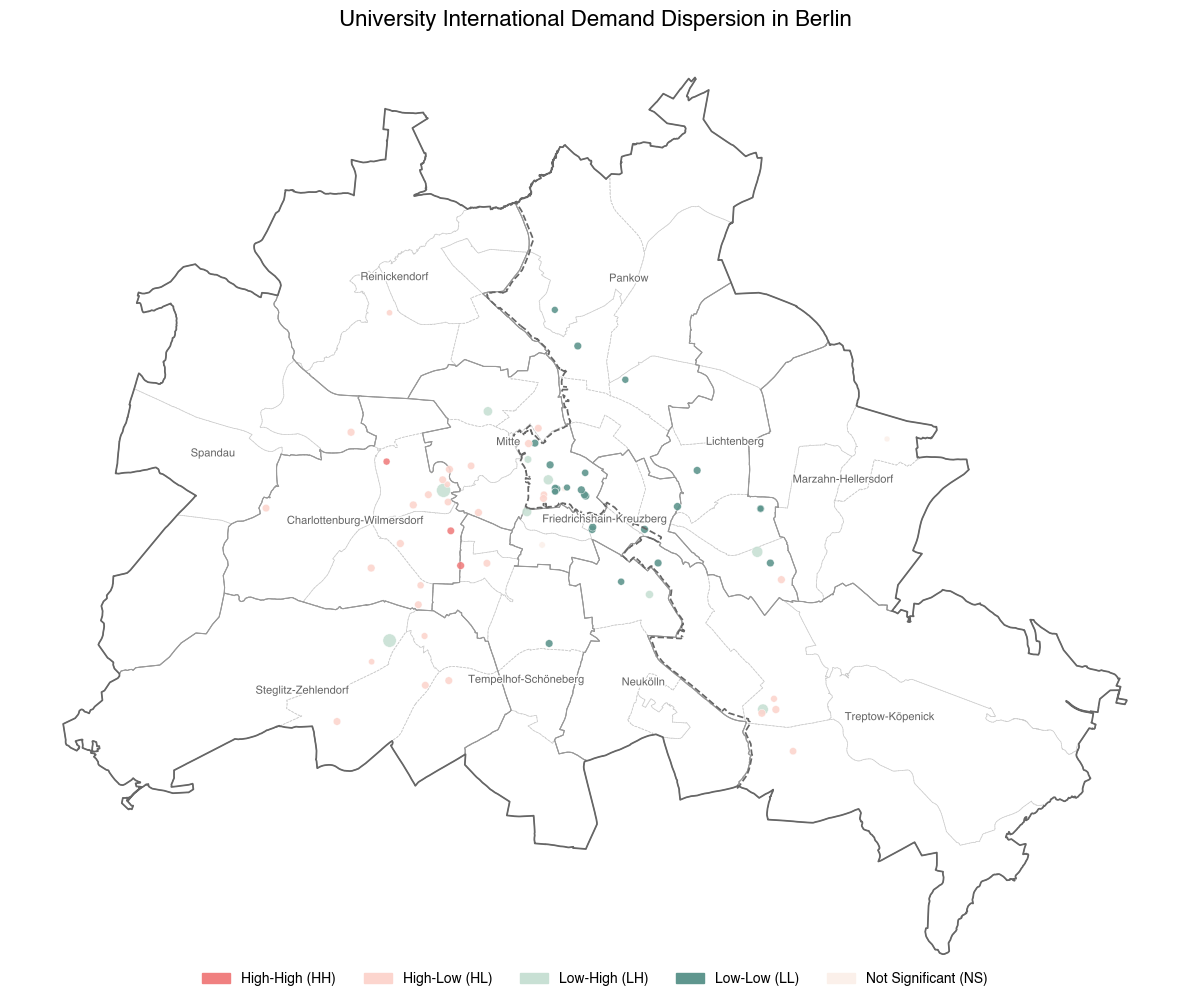

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))

# Replace pgr, bz, out with your base layers if needed
pgr.plot(ax=ax, facecolor='none', edgecolor='#cccccc', linewidth=0.5, linestyle="--")
mauer.plot(ax=ax, facecolor='none', edgecolor='#666666', linewidth=1.25, linestyle="--")
bz.plot(ax=ax, facecolor='none', edgecolor='#999999', linewidth=0.75)
for idx, row in bz.iterrows():
    centroid = row['geometry'].centroid
    txt = ax.text(
        centroid.x, centroid.y,
        str(row['namgem']),
        fontsize=8, color='#666666', ha='center', va='center'
    )
    txt.set_path_effects([
        path_effects.Stroke(linewidth=2, foreground='white'),
        path_effects.Normal()
    ])

out.plot(ax=ax, facecolor='none', edgecolor='#666666', linewidth=1.25)

uni_c.plot(ax=ax,
           color=uni_c['color'],
           markersize=np.sqrt(np.abs(uni_c['!s_aus_std'])) + 5,
           alpha=0.9,
           edgecolor='white',
           linewidth=0.3)

legend_elements = [
    mpatches.Patch(color='#F08080', label='High-High (HH)', edgecolor='none'),
    mpatches.Patch(color='#FCD5CE', label='High-Low (HL)', edgecolor='none'),
    mpatches.Patch(color='#C8E0D4', label='Low-High (LH)', edgecolor='none'),
    mpatches.Patch(color='#5F968E', label='Low-Low (LL)', edgecolor='none'), 
    mpatches.Patch(color='#FBF0EA', label='Not Significant (NS)', edgecolor='#FAE1DD'), 
]

uni_c['color'] = colors
uni_c['cluster'] = clusters

ax.legend(handles=legend_elements, loc='lower center', ncol=5, frameon=False, prop={'size': 10})
ax.set_title('Higher Education Universities International Demand Dispersion in Berlin', fontsize=16, weight='bold')
ax.set_axis_off()

save_path = os.path.join(hf, "Higher_Education_Universities_International_Demand_Dispersion_in_Berlin.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()

*Figure XX. Higher Education Universities International Demand Dispersion in Berlin*

## Data Export

In [32]:
# List of columns to drop
cols_to_drop = [f'!s_aus_slag_std_k{i}' for i in range(1, 21)]

# Drop them from the GeoDataFrame
uni_c = uni_c.drop(columns=cols_to_drop)

The data on higher education universities' international students demand obtained as a result of global spatial autocorrelation was collected for further market analysis.

In [33]:
hf = r'../outputs/2.4_global_spatial_autocorrelation/uni_int_demand_analysis.gpkg'
uni_c.to_file(hf, driver="GPKG")